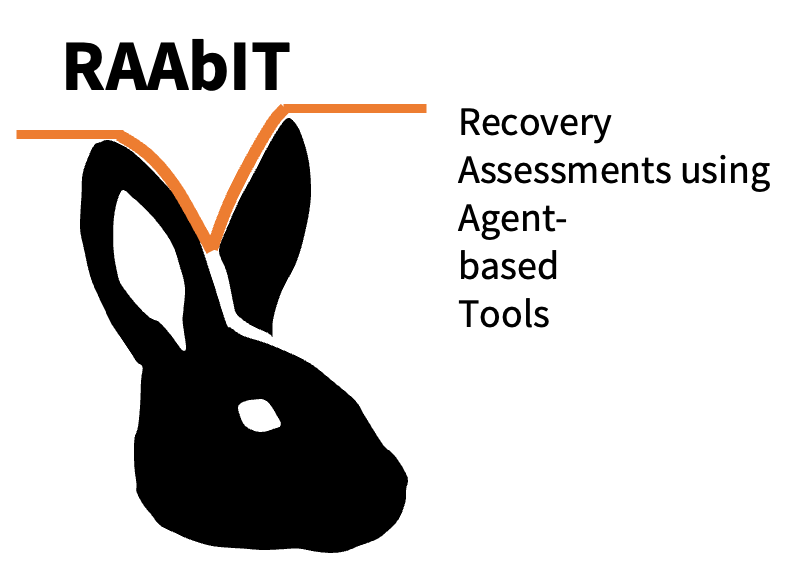

RAAbIT (Recovery Assessment using Agent-based Tools) is a an agent-based model developed to simulate post-disaster housing recovery. The philosophy behind the model's development was that it should only require data that are accessible within weeks of a disaster and that all of its agents' behaviors are modeled according to the best available statistical data. Thus, RAAbIT can be employed for planning before or shortly after a disaster, and it is not overfit to one case study. The behaviors of RAAbIT's agents follow conditional probability models developed based on historical, publicly available datasets. When reliable data are not publicly available, 'levers' are included in the model based on empirical observations of past disasters. These levers (e.g., availability of contractors) allow users to control aspects of the simulation to best represent their expectations of the community's recovery process (e.g., recovery is expected to be limited by contractor availability or not).

A manuscript describing the model and including an OOD is found here: [RAAbIT documentation](https://github.com/rccosta1/RAAbiT/blob/a70328f1738524562fa0aeaed4bd52114db0756a/RAAbIT%20Documentation%20Paper%20%5Bpreprint%5D.pdf)

Lee, J., Costa, R., & Baker, J. W. (2024). [Post-disaster housing recovery estimation: Data and lessons learned from the 2017 Tubbs and 2018 Camp Fires](https://www.sciencedirect.com/science/article/pii/S2212420924006745?casa_token=OEWfbP0KZO0AAAAA:yC0yIPlTsJYr8SuY9QQopQWuBgcrurH5qJ7tGJbFbWMMLGiAt9rOgQ7sh5Mp4YpuWOKA5-ob). International Journal of Disaster Risk Reduction, 114, 104912.

Costa, R., Bolte, E., Sharp, C., & Bowers, C. (2024). [Repeated and localized flooding is an underestimated challenge for urban disaster risk management](https://www.nature.com/articles/s44284-024-00107-8). Nature Cities, 1(9), 587-596.

Mongold, E., Costa, R., Zsarnóczay, Á., & Baker, J. W. (2024). [Modeling post-disaster recovery: Accounting for rental and multi-family housing](https://journals.sagepub.com/doi/full/10.1177/87552930231222769?casa_token=xHj29HDfQtgAAAAA%3Aqxj2OKEe3QtGKRJOgUGrdiQrHd-6fCzKTlfpE22mCvzPa4h-EuTgJGBFe7ClEm6n1PQwXK0D3oI). Earthquake Spectra, 40(2), 1353-1375.

Costa, R., & Baker, J. W. (2024). [A methodology to estimate postdisaster unmet housing needs using limited data: Application to the 2017 California wildfires](https://onlinelibrary.wiley.com/doi/full/10.1111/risa.14206). Risk Analysis, 44(4), 850-867.

Costa, R., Wang, C., & Baker, J. W. (2022). [Integrating place attachment into housing recovery simulations to estimate population losses](https://ascelibrary.org/doi/full/10.1061/(ASCE)NH.1527-6996.0000571?casa_token=GG1AaCdAZVIAAAAA:bMm2yhBfrDvhIi0u4qHDl-Cf6qHBeDltP6DpWC18oPzPY4gD2jO3CsSmNxYj_jFUXnWBWcTRYg&casa_token=g_E1DLMeM2UAAAAA:hP84VxvUTMGg6HumDS0-BytE17Y1A1rnd7V2QPhF5VHBF8UfU_vgLHCVYgZ9R0aTyOUHIcSn8A). Natural Hazards Review, 23(4), 04022021.

Alisjahbana, I., Moura-Cook, A., Costa, R., & Kiremidjian, A. (2022). [An agent-based financing model for post-earthquake housing recovery: Quantifying recovery inequalities across income groups](https://journals.sagepub.com/doi/full/10.1177/87552930211064319?casa_token=orYE8p1Exo4AAAAA%3AhnSZKV7mhC8d1OZwIBsMUpxqfG0EtRcthxdGH7VgBP0gGrot2OPns4LNbxDlZwR8Be2whZShJn0). Earthquake Spectra, 38(2), 1254-1282.

Wang, C., Costa, R., & Baker, J. W. (2022). [Simulating post-disaster temporary housing needs for displaced households and out-of-town contractors](https://journals.sagepub.com/doi/full/10.1177/87552930221112690?casa_token=E9CezhwCtbMAAAAA%3AhFhn-vgSBIEujfTzCa5B1MmNZr1YIXRYBUdYx3J4e9PrPJurtq5U5t6gHifaZpATGBNIAMJ831M). Earthquake Spectra, 38(4), 2922-2940.

Costa, R., Haukaas, T., & Chang, S. E. (2021). [Agent-based model for post-earthquake housing recovery](https://journals.sagepub.com/doi/full/10.1177/8755293020944175?casa_token=FqPb60DSUQ0AAAAA%3A9sGP9p4SBBXI-SHB8m4uF9p8eWu3lzQF76e9eRmbFD_qhK64FeLO9g2C5KYrmU71cv57PZF1N0w). Earthquake Spectra, 37(1), 46-72.



---



# Imports

In [81]:
print('Importing required packages. This may take a while.')
!pip install cpi
!pip install requests
!pip install censusdata

import weakref
import pandas as pd
import cpi
import math
import requests
import censusdata
import random

import numpy as np
from numpy.random import default_rng
from numpy.linalg import inv, det

import scipy
from scipy import stats as sts

from plotnine import *

from sklearn.neighbors import NearestNeighbors


# Settings the warnings to be ignored
import warnings
warnings.filterwarnings('ignore')

rng = default_rng(13)

Importing required packages. This may take a while.




---



---



# <font color='orange'> RAAbIT </font>

RAAbIT is the engine for housing recovery simulations using agent-based simulations.

## <font color='orange'> Service Provider Agents </font>

Service provider agents represent a group of agents that facilitate the physical repairs of housing. These include permit assessors, engineers, and contractors. Currently, RAAbIT does not include an agent to represent inspectors. Inspections are crucial for modelling short-term displacements (e.g., temporary shelter needs) but add little when long-term recovery is considered due to inspections being completed with days/weeks.

### <font color='orange'> Contractor Job Market Agent </font>

In [82]:
class ContractorMarket():
    instances = set()

    # Constructor
    def __init__(self,local_contractors=0,r=0.5,tnw={},bhv='FCFS'):
        self.object_name = 'JobMarket'
        self.R = r
        self.__class__.instances.add(self)
        self.demand = 0
        self.number_new_contractors = 0
        self.local_contractors = local_contractors
        self.timeline_contractors = tnw
        self.contractor_behavior = bhv
        self.contractor_surplus = 0
        self.last_evaluation_time = 0


    # Destructor
    def __del__(self):
        print('Destructor called.', self.object_name, 'deleted.')


    # Get instances
    @classmethod
    def get_instances(cls):
        dead = set()
        for ref in cls._instances:
            obj = ref()
            if obj is not None:
                yield obj
            else:
                dead.add(ref)
        cls._instances -= dead


    # Reset
    def reset_time(self):
        self.number_new_contractors = 0
        self.demand = 0
        self.contractor_surplus = 0
        self.last_evaluation_time = 0

    # Set responsiveness
    def set_R(self, value):
        self.R = value

    # Set local contractors
    def set_local_contractors(self, value):
        self.local_contractors = value

    # Step
    def assess(self,t,list_of_contractors,job_listings):
        #print(f'The job list has {len(list_of_contractors)} listings.')

        # If a time series of workers is provided
        if bool(self.timeline_contractors) == True:

            dic_nwb = self.timeline_contractors

            Delta_x = list(dic_nwb.keys())[1] - list(dic_nwb.keys())[0]
            tt = t / 365
            dt = t - self.last_evaluation_time
            Delta_y = dic_nwb[max(k for k in dic_nwb if k <= tt+Delta_x)] - dic_nwb[max(k for k in dic_nwb if k <= tt)]#self.timeline_contractors[tt+Delta_x//Delta_x] - self.timeline_contractors[tt//Delta_x]
            delta_x = tt - list(dic_nwb.keys())[list(dic_nwb.values()).index(dic_nwb[max(k for k in dic_nwb if k <= tt)])]

            contractors_to_add_at_t = int((dt/365) * Delta_y / Delta_x)

            if contractors_to_add_at_t > 0:
                for i in range(contractors_to_add_at_t):
                        self.number_new_contractors += 1
                        list_of_contractors.append(RContractor('new_' + str(self.number_new_contractors), rng.random() * 30,self.contractor_behavior))

            else:
                self.contractor_surplus += np.abs(contractors_to_add_at_t)
                unemployed_contractors = [c for c in range(len(list_of_contractors)) if list_of_contractors[c].employed == False][:np.abs(int(self.contractor_surplus))]
                for index in sorted(unemployed_contractors, reverse=True):
                    if len(list_of_contractors) > 1:
                        del list_of_contractors[index]
                        self.contractor_surplus -= 1

        elif self.R > 0:

            # The demand for out-of-town workers
            self.demand = len(job_listings)
            allocated_contractors = np.sum([1 if c.employed == True else 0 for c in list_of_contractors])
            available_contractors = np.sum([1 if c.employed == False else 0 for c in list_of_contractors])

            supply_demand_gap = math.floor(self.R * (self.demand + allocated_contractors)\
                                                      - (available_contractors + allocated_contractors))
            # print(f'The supply-demand gap is {supply_demand_gap}')

            # Bring in new contractors
            if supply_demand_gap > 0:

                for i in range(supply_demand_gap):
                    self.number_new_contractors += 1
                    list_of_contractors.append(RContractor('new_' + str(self.number_new_contractors), rng.random() * 30,self.contractor_behavior))
                    self.demand -= 1
                #print(f'Added {supply_demand_gap} and now have {len(list_of_contractors)} in total.')

            # Remove contractors
            elif supply_demand_gap + self.local_contractors < 0:
                unemployed_contractors = [c for c in range(len(list_of_contractors)) if list_of_contractors[c].employed == False][:np.abs(int(supply_demand_gap/2))]

                for index in sorted(unemployed_contractors, reverse=True):
                    if len(list_of_contractors) > 1:
                        del list_of_contractors[index]


        self.last_evaluation_time = t
        return list_of_contractors

### <font color='orange'> Baseline Contractor Firm Agent </font>

In [83]:
class RContractor():
    instances = set()

    # Constructor
    def __init__(self,name,distance,bhv):
        self.object_name = name
        self.employed = False
        self.__class__.instances.add(self)
        self.behavior = bhv
        self.distance = distance


    # Destructor
    def __del__(self):
        pass
        #print('Destructor called.', self.object_name, 'deleted.')


    # Reset
    def reset_time(self):
        pass


    def dismiss(self):
        self.employed = False
        #print('I am unemployed', self.object_name)


    def step(self, joblistings):

        # If not employed
        if self.employed == False:

            # find first building without a contractor
            if self.behavior == 'FCFS':

                for i in joblistings:
                    if i.contractors_on_site == 0 and self.employed == False:
                        i.assign_contractor(self)
                        self.employed = True
                        break


            # prioritize based on urban density
            elif self.behavior == 'Density':

                df_aux = pd.DataFrame()
                df_aux['buildings'] = joblistings
                df_aux['neighbors'] = [b.neighbors for b in joblistings]

                df_aux.sort_values(by='neighbors', ascending=False, inplace=True)

                for i in df_aux['buildings']:
                    if i.contractors_on_site == 0 and self.employed == False:
                        i.assign_contractor(self)
                        self.employed = True
                        break


            # randomly pick one building without a contractor
            elif self.behavior == 'Random':

                for i in random.sample(joblistings,len(joblistings)):
                    if i.contractors_on_site == 0 and self.employed == False:
                        i.assign_contractor(self)
                        self.employed = True
                        break

            else:
                print('I do not recognize this worker behavior!!')

### <font color='orange'>Engineering Firm Agent</font>

The Engineering Firm Agent provides engineering assessments to buildings that are significantly damaged. The main attributes of this agent are listed in the table below. One of these attributes is a the number of assessments that can be conducted at the same time. Conceptually, this is different from the number of engineers in the community because one engineer may work on multiple assessments simultaneously. Estimating this attribute is not trivial. One alternative is to evaluate the number of building completions per year in the community. That will provide a lower boundary for the number of engineering assessments that can be conducted simultaneously. The other two attributes refer to the time it takes for the assessment to be completed, which is modeled as a lognormal distribution. The default values in RAAbIT are the conditional estimates provided in [REDi](https://www.arup.com/perspectives/publications/research/section/redi-rating-system). This model's implementation and its interaction with the Building Agents are similar to the interactions of the Local Contractor Firm Agent.

The Engineering Firm Agent collects requests for *engineering assessments* from the building agents. On a fist-come-first-served basis assessments start. Assessments take *t_eng* to complete. Once the assessment is completed, the building agent is informed so it can proceed with its repair activities. If more assessment requests are received than the Engineering Firm Agent's capacity to process them, the requests are queue. Whenever one assessment is completed, the first on in the queue starts. Thus, although it takes $t_eng$ to complete an assessment, the total time for a building agent to receive an engineering assessment may be significantly larger due to the wait in the queue.

<br>

| Attribute | Explanation | Value/Metric | Source |
| --- | --- | --- | --- |  
|baseline_assessments | Number of simultaneous assessments | integer | -- |
|allocated_engineers  | Number of assessments being conducted | integer | -- |
|available_engineers  | baseline_assessments - allocated_engineers | integer | -- |
|theMedianAssessmentTime | Median time to complete an assessment | [days] | [REDi](https://www.arup.com/perspectives/publications/research/section/redi-rating-system) |
|theDispersionOfAssessmentTime | Dispersion of time to complete an assessment | [days] | [REDi](https://www.arup.com/perspectives/publications/research/section/redi-rating-system) |



In [84]:
# Engineering Firm
'''
  Implemented by Rodrigo Costa, December 2021
  This class is used to instantiate an engineering firm with nwb engineering teams.
  On each time step, the firm checks all neighborhood objects to check if they have Requests for engineering services.
'''

class REngineeringFirm():
    _instances = set()

    # Constructor
    def __init__(self,name,nwb,ol='Minimum'):
        self._instances.add(weakref.ref(self))
        self.object_name = name
        self.baseline_assessments = nwb
        self.available_engineers = nwb
        self.allocated_engineers = 0
        self.last_evaluation_time = 0
        self.df_requests = pd.DataFrame(columns=['Requester','Type','Amount','Bid'])
        self.output_level = ol


    # Destructor
    def __del__(self):
        pass
        #print('Destructor called.', self.object_name, 'deleted.')

    # Get instances
    @classmethod
    def get_instances(cls):
        dead = set()
        for ref in cls._instances:
            obj = ref()
            if obj is not None:
                yield obj
            else:
                dead.add(ref)
        cls._instances -= dead

    # Reset
    def reset_time(self):
        self.available_engineers = self.baseline_assessments
        self.allocated_engineers = 0
        self.df_requests = self.df_requests.iloc[0:0]


    # Object name
    def get_object_name(self):
        return self.object_name


    # Simulate a engineer being dismissed after finishing a job and being available again
    def dismiss_engineer(self,value):
        self.available_engineers += value
        #print('A engineering team was dismissed to',self.object_name,'. Current available contractors:',self.available_contractors)


    # Determine how many engineers can be allocated to buildings on this time step
    def get_supply_capacity(self,s,n):
        the_capacity = 0
        for i in range(len(s)):
            the_capacity += s[i] if the_capacity <= n else 0

        return the_capacity


    #Determine how long will take to assess each buildings (based on REDi numbers)
    def get_assessment_time(self):

        return 0


    def set_request(self,df):
        df.loc[0,'TimeNeededForAssessment'] = self.get_assessment_time()
        self.df_requests = pd.concat([self.df_requests,df],ignore_index=True)

        if self.output_level == 'Maximum':
            print(self.object_name,'received a request from', df.loc[0,'Requester'])


    # Main
    def step(self,t):

        if t == 0:
            self.reset_time()

        # Get hold of which requests were supplied
        indexes_to_remove = []

        # Figure out how many Deliveries to send
        deliveries_to_send = int(self.get_supply_capacity(list(self.df_requests['Amount']),self.available_engineers))

        # Loop over the Deliveries to be sent
        for i in range(deliveries_to_send):
            the_amount_requested = self.df_requests.loc[i,'Amount']

            # Check if resources are available
            if self.available_engineers > the_amount_requested:

                self.df_requests.loc[i,'TimeNeededForAssessment'] -= max(0.0,t - self.last_evaluation_time)

                if self.df_requests.loc[i,'TimeNeededForAssessment'] <= 0.0:

                    # Ship a Delivery to supply this requester
                    self.df_requests.loc[i,'Requester'].set_delivery(the_amount_requested,'EngineeringAssessment')

                    # Remove this row
                    indexes_to_remove.append(i)

                    self.available_engineers -= the_amount_requested


        # Remove this request from the list
        self.df_requests = self.df_requests.drop(indexes_to_remove,axis=0)
        self.df_requests.reset_index(drop=True,inplace=True)

        self.allocated_engineers = self.baseline_assessments - self.available_engineers

        self.last_evaluation_time = t

        return 1

### <font color='orange'>Permit Assessor Agent</font>

In [85]:
class RPermitAssessor():
    _instances = set()

    # Constructor
    def __init__(self,name,mode,fixed=0,ua=0,ub=0,dic={}):
        self._instances.add(weakref.ref(self))
        self.object_name = name
        self.mode = mode
        self.fixed_value = fixed
        self.u_a = ua
        self.u_b = ub
        self.timeseries = dic
        self.last_evaluation_time = 0


    # Destructor
    def __del__(self):
        pass
        #print('Destructor called.', self.object_name, 'deleted.')


    # Get instances
    @classmethod
    def get_instances(cls):
        dead = set()
        for ref in cls._instances:
            obj = ref()
            if obj is not None:
                yield obj
            else:
                dead.add(ref)
        cls._instances -= dead


    # Reset
    def reset_time(self):
        self.last_evaluation_time = 0


    # Object name
    def get_object_name(self):
        return self.object_name


    def get_permitdelay(self):

        d = 0

        if self.mode == 'Fixed':
            d = self.fixed_value

        elif self.mode == 'Uniform':
            d = rng.integer(low=self.u_a, high=self.u_b)

        elif self.mode == 'TimeSeries':
            d = 0 # not implemented yet

        else:
            print(self.object_name, 'cannot identify permit delay mode.')

        return d

## <font color='orange'> Financing Provider Agents</font>

### <font color='orange'> Insurance Company Agent </font>

This agent represents all insurance companies within the community. Rather than representing the insurance market's intricacies, this agent's role is to represent the *average* behaviour of the insurance companies.



In [86]:
# Insurance company class
class RInsuranceCompany():
  _instances = set()

  # Constructor
  '''
  Default parameters as per REDi:
    - funding disbursement follows a lognormal distribution ~ LN(42,1.11) days
    - coverage is assumed 100% of the building replacement cost by default
    - deductible is assumed 15% of the building replacement cost by default
  '''
  def __init__(self,name,deductible=0.15,ins_coverage=1,t_med=42,t_beta=1.11):
        self.object_name = name
        self.ins_med = t_med
        self.ins_beta = t_beta
        self.deductible = deductible
        self.coverage = ins_coverage
        self._instances.add(weakref.ref(self))
        self.last_evaluation_time = 0


  # Destructor
  def __del__(self):
      pass
      #print('Destructor called.', self.object_name, 'deleted.')


  # Get instances
  @classmethod
  def get_instances(cls):
      dead = set()
      for ref in cls._instances:
          obj = ref()
          if obj is not None:
              yield obj
          else:
              dead.add(ref)
      cls._instances -= dead


  def reset_time(self):
      return 0


  # Get object name
  def get_object_name(self):
      return self.object_name


  # Median insurance payment time
  def get_insurance_payment_median(self):
      return self.ins_med


  def set_insurance_payment_median(self,value):
      self.ins_med = value


  def get_insurance_payment(self, balance, replacement_cost):
      ins_pay = 0
      ins_time = 0

      # Calculate funds received and disbursement time
      if balance > 0:

          ins_pay = np.maximum(np.minimum(balance - self.deductible*replacement_cost,self.coverage*replacement_cost),0)
          ins_time = np.random.lognormal(np.log(self.ins_med), self.ins_beta) + 7 # assuming one week between each step

      return ins_pay, ins_time

### <font color='orange'> FEMA Individuals Assistance Program </font>

In [87]:
class RFEMAIAP():
  _instances = set()

  # Constructor
  '''
  Disbursement time:
      Median days to payment: 37, Table 2 in https://www.gao.gov/assets/720/710174.pdf
      Assuming more or less 10 days, i.e., u[27,47]

  Approval and amount:
      See 4.3 in https://onlinelibrary.wiley.com/doi/full/10.1111/risa.14206
  '''

  def __init__(self,name,ref_year,cap=42500,t_low=27,t_high=47):

        self.object_name = name
        self._instances.add(weakref.ref(self))
        self.last_evaluation_time = 0
        self.fema_time_low = t_low
        self.fema_time_high = t_high

        # FEMA cap for the year are published by the Registrars Office, e.g., https://www.federalregister.gov/documents/2024/01/22/2024-00677/individual-assistance-program-equity
        dict_fema_cap = {2024:42500, 2023:41000, 2022:41000,
                         2021:37900}
        self.fema_Cap = dict_fema_cap[ref_year] if ref_year in dict_fema_cap.keys() else cpi.inflate(dict_fema_cap[2022],2022,ref_year)


  # Destructor
  def __del__(self):
      pass
      #print('Destructor called.', self.object_name, 'deleted.')


  # Get instances
  @classmethod
  def get_instances(cls):
      dead = set()
      for ref in cls._instances:
          obj = ref()
          if obj is not None:
              yield obj
          else:
              dead.add(ref)
      cls._instances -= dead


  # Get object name
  def get_object_name(self):
      return self.object_name


  def reset_time(self):
      self.last_evaluation_time = 0


  # Get the approval rate based on demographics
  def get_FEMA_approval_rate(self,income,residence,insurance,loss):
      ihp_app = 0
      fvl = np.minimum(loss / 2.03,self.fema_Cap) # SBA-fvl multiplier, HCD 2019 page 77

      if fvl > 0:
          if insurance == 'Uninsured':
              if fvl < 5000:

                  if income == 'High':
                      ihp_app = 0.518

                  elif income == 'Moderate':
                      ihp_app = 0.519

                  elif income == 'Low':
                      ihp_app = 0.523

                  else:
                      ihp_app = 0.527

              else:
                  if income == 'High':
                      ihp_app = 0.756 - 7.9*10**-6 * fvl

                  elif income == 'Moderate':
                      ihp_app = 0.799 - 1.9*10**-6 * fvl

                  elif income == 'Low':
                      ihp_app = 0.829 - 2.2*10**-6 * fvl

                  else:
                      ihp_app = 0.838 - 3.3*10**-6 * fvl


          elif insurance != 'Uninsured':
              if fvl < 5000:

                  if income == 'High':
                      ihp_app = 0.303

                  elif income == 'Moderate':
                      ihp_app = 0.2965

                  elif income == 'Low':
                      ihp_app = 0.2897

                  else:
                      ihp_app = 0.294

              else:
                  if income == 'High':
                      ihp_app = 0.481 - 3.9*10**-6 * fvl

                  elif income == 'Moderate':
                      ihp_app = 0.541 - 3.8*10**-6 * fvl

                  elif income == 'Low':
                      ihp_app = 0.556 - 4.2*10**-6 * fvl

                  else:
                      ihp_app = 0.577 - 2.8*10**-6 * fvl

      return ihp_app


  # Get the approval rate based on demographics
  def get_FEMA_approval_amount(self,income,residence,insurance,loss):
      ihp_amt = 0

      fvl = np.minimum(loss / 2.03,self.fema_Cap) # SBA-fvl multiplier, HCD 2019 page 77

      if insurance == 'Insured' and income == 'High':
          ihp_amt = -7.7*10**-6 * fvl * fvl + 0.786 * fvl + 10385

      elif insurance == 'Insured' and income != 'High':
          ihp_amt = -8.4*10**-6 * fvl * fvl + 0.877 * fvl + 8335

      elif insurance != 'Insured':
          ihp_amt = -1.47*10**-5 * fvl * fvl + 1.22 * fvl + 6201

      return ihp_amt


  def get_FEMA_grant(self,income,residence,insurance,loss,balance):
      '''
      Function to calculate FEMA loan received for a single house
      Input:
      income [float]: household income
      loss [float]: the immediate loss
      balance [float]: remaining dollars needed to reconstruct
      Output:
      fema: amount of aid received
      fema_time: time to receive
      '''
      prob = rng.random()
      fema_time = 0
      fema_total = 0

      if residence == 'House/Duplex':
          # FEMA grant properties
          theFEMAApprovalRate = self.get_FEMA_approval_rate(income,residence,'Insured' if insurance == True else 'Uninsured',loss)
          theFEMAAMount = self.get_FEMA_approval_amount(income,residence,'Insured' if insurance == True else 'Uninsured',loss)


          if prob < theFEMAApprovalRate and balance > 0: # eligible for fema
              fema_fund = min(theFEMAAMount, self.fema_Cap) # maximum funding from fema
              fema_total = min(fema_fund, balance) # amount received
              fema_time = rng.integers(self.fema_time_low,self.fema_time_high) + 7 # assuming one week between each step


      return fema_total, fema_time

### <font color='orange'>Small Business Administration Agent</font>

In [88]:
# SBA class
class RSBA():
  _instances = set()

  '''
  Disbursement time:
      - As per REDi, lognormal distribution ~ LN(45,0.57) days

  Approval and amount:
      - See 2.5.3 in https://dx.doi.org/10.21203/rs.3.rs-3313717/v1
      - Cap for business is $2,000,000 - assumed the same for rental housing

  Maturity and interest rate: https://www.sba.gov/funding-programs/disaster-assistance/physical-damage-loans
      - Maturity 30 years
      - Interest rate: <4% annually if does not qualify for bank loan, <8% annually otherwise

  Requirements: https://www.sba.gov/funding-programs/disaster-assistance/physical-damage-loans
      - Collateral is required to the extent possible for physical damage loans over $25,000 in Presidential declarations and $14,000 in agency declarations.
  '''

  # Constructor
  def __init__(self,name,ref_year,pres_dec=True,owner_cap=500000,business_cap=2000000,loan_mat=30,t_med=45,t_beta=0.57,sba_min=25000):
        self.object_name = name
        self._instances.add(weakref.ref(self))
        self.last_evaluation_time = 0
        self.sba_loan_maturity = loan_mat
        self.sba_gdsr = 0.3
        self.sba_cap = owner_cap if ref_year >= 2024 else 200000 # Minimum amount changed in August, 2023
        self.sba_Business_cap = business_cap
        self.sba_med = t_med # days, median
        self.sba_beta = t_beta # dispersion

        if pres_dec == True:
            self.sba_min = sba_min
        else:
            self.sba_min = 14000


  # Destructor
  def __del__(self):
      pass
      #print('Destructor called.', self.object_name, 'deleted.')


  # Get instances
  @classmethod
  def get_instances(cls):
      dead = set()
      for ref in cls._instances:
          obj = ref()
          if obj is not None:
              yield obj
          else:
              dead.add(ref)
      cls._instances -= dead


  # Get object name
  def get_object_name(self):
      return self.object_name


  def reset_time(self):
      self.last_evaluation_time = 0


  # Median payment time
  def get_SBA_payment_median(self):
      return self.sba_med
  def set_SBA_payment_median(self,value):
      self.sba_med = value


  def get_SBA_loan(self,tenure,loss,balance):
      '''
      Function to calculate SBA loan received for a single house
      Input:
      income [float]: household income
      loss [float]: the immediate loss
      balance [float]: remaining dollars needed to reconstruct
      Output:
      sba: amount of aid received
      sba_time: time to receive
      '''

      my_tenure = tenure
      my_loss = loss
      sba_amt = 0

      sba_time = rng.lognormal(np.log(self.sba_med), self.sba_beta) + 7 # assuming one week between each step


      # Owner-occupied
      if my_tenure == 'owner_occupied':
          sba_app = True if rng.random() < np.minimum(1,np.exp(-0.0053 * np.log(my_loss)**2 + 0.2394*np.log(my_loss) - 2.2594)) else False

          if sba_app == True:
              sba_amt = min(0.4692 * my_loss + 1891.9,balance,self.sba_cap)


      # Renter-occupied
      elif my_tenure == 'renter_occupied':
          sba_app = True if rng.random() < np.minimum(1,np.exp(-0.0053 * np.log(my_loss)**2 + 0.2394*np.log(my_loss) - 2.2594)) else False

          if sba_app == True:
              sba_amt = min(0.4692 * my_loss + 1891.9,balance,self.sba_Business_cap)

      return sba_amt, sba_time

### <font color='orange'>Bank Agent</font>

The Bank Agent interacts with households to provide loans with market-rate interests. These loans are assumed to be less appealing than those provided by the SBA Agent. That is, Household Agents will always seek a loan from the SBA Agent before they seek a loan from the Bank Agent.

The maximum loan $P$ from the Bank Agent is conditioned on the income of the applicant:


\begin{equation}
    P = G \cdot \Big(I/12\Big) \cdot \Big((1+r)^n - 1\Big) / \Big(r \cdot (1 + r)^n \Big)
\end{equation}


where *P* is the maximum loan amount, *G* is the maximum gross debt-to-income ratio, *I* is the loaner household income, *r* is the monthly interest rate at current year, and *n* is the loan maturity. By default, *G*=0.3 and *n*=30 years in RAAbIT. However, these values should be tailored to specific applications.

If the homeowner has equity in his current home, *E*, that can be used to get a potentially larger loan. The effective equity, $EE$, is the difference between the pre-disaster equity and the disaster-induced losses, and it is calculated as


\begin{equation}
    EE = \frac{y_{current} - y_{bought}}{n} \cdot HV - Loss
\end{equation}


where $y_{current}$ and $y_{bought}$ are the current year and the year the home was bought, and $HV$ is the home value.



In [89]:
# Bank class
class RBank():
  _instances = set()

  '''
  Disbursement time:
      - As per REDi, lognormal distribution ~ LN(60,0.68) days

  Maturity:
      - Assume equal to SBA's: 30 years

  Interest rate:
      - Assume equal to SBA's for when the applicant would qualify for private loan: 8% annually

  Requirements:
      - A loan applicant cannot commit more than 30% of their income for a loan payment, gdsr = 0.3
  '''

  # Constructor
  def __init__(self,name,loan_mat=30,t_med=60,t_beta=0.68):
        self.object_name = name
        self.bank_med = t_med
        self.bank_beta = t_beta
        self.bank_loan_maturity = loan_mat
        self.bank_gdsr = 0.3
        self._instances.add(weakref.ref(self))
        self.last_evaluation_time = 0


  # Destructor
  def __del__(self):
      pass
      #print('Destructor called.', self.object_name, 'deleted.')


  # Get instances
  @classmethod
  def get_instances(cls):
      dead = set()
      for ref in cls._instances:
          obj = ref()
          if obj is not None:
              yield obj
          else:
              dead.add(ref)
      cls._instances -= dead


  def reset_time(self):
      return 0


  # Median insurance payment time
  def get_bank_payment_median(self):
      return self.bank_med
  def set_bank_payment_median(self,value):
      self.bank_med = value

  # Get object name
  def get_object_name(self):
      return self.object_name


  def get_private_loan(self, income, tenure, equity, value, loss, balance):

      # Inputs
      my_income_value = income
      my_tenure = tenure
      my_value = value
      my_equity = equity
      my_loss = loss
      bank_time = 0
      bank_amt = 0


      # Single-family owner-occupied
      if my_tenure == 'owner_occupied':

          # Maximum loan
          max_loan = 0

          # Calculate the maximum loan amount
          # We use the mortgage equation to calculate P, the loan amount
          # M = P * r * (1 + r)**n / ((1+r)**n - 1)
          # P = 0.3 * M * ((1+r)**n - 1) / (r * (1 + r)**n)
          r = 0.08 / 12 # monthly interest rate at the last year in the dataframe
          n = self.bank_loan_maturity * 12 # maturity [months]
          P = self.bank_gdsr * (my_income_value/12) * ((1+r)**n -1) / (r*(1+r)**n)
          max_loan = np.minimum(P,np.maximum(my_equity - loss,0))
          bank_amt = np.minimum(balance, max_loan)
          bank_time = np.random.lognormal(np.log(self.bank_med), self.bank_beta) + 7 # assuming one week between each step


      # Single-family Owner-occupied
      elif my_tenure == 'renter_occupied':

          # Calculate the maximum loan amount
          max_loan = np.maximum(my_equity - loss,0)
          bank_amt = np.minimum(balance, max_loan)
          bank_time = np.random.lognormal(np.log(self.bank_med), self.bank_beta) + 7 # assuming one week between each step


      return bank_amt, bank_time

<font color='orange'>HUD Community Development Block Grant for Disaster Recovery</font>

The US Department of Housing and Urban Development (HUD) provides disaster recovery assistance to states impacted by disaster through its Community Development Block Grants for Disaster Recovery (CDBG-DR) programs. The CDBG-DR program is not part of HUD's mandate. Thus, after a Major Disaster Declaration, HUD appropriates funding needs to be approved by Congress before it is allocated to communities. Once funding is allocated, communities design Action Plans which must be approved by HUD to result in a funding award. Moreover, state authorities do not receive all funding at once. Multiple years may pass between the initial allocation and the completion of the program. Data collected by [Martin et al (2021)](https://www.tandfonline.com/doi/full/10.1080/10511482.2021.1875258) from multiple disaster to demonstrate the variability in the timelines of CDBG-DR funding disbursement. Thus, the models for CDBG-DR funding disbursement include five actions: (i) time between disaster and appropriation, (ii) time between appropriation and allocation, (iii) time between allocation and award, (iv) time between award and first expenditure, and (v) time between expenditure and program completion.

A minimum of 80% of CBDG-DR funding must be employed to the help the most disrupted areas, and about 70% should used to help low-to-moderate income households. Beyond that, grantee states are free to employ the funding according to their needs. In previous disasters, different programs were created grantees focusing on (i) single-family owner-occupied buildings, (ii) single-family affordable rental buildings, (iii) multi-family owner-occupied buildings, and (iv) multi-family affordable rental buildings. Not all grantees implement all programs. To increase its versatility, RAAbIT includes three models to simulate funding coming from CDBG-DR. These models represent past implementations of CDBG-DR programs and are **not guaranteed to be implemented in future disasters. Users are encouraged to critically evaluate if these programs will be available**.


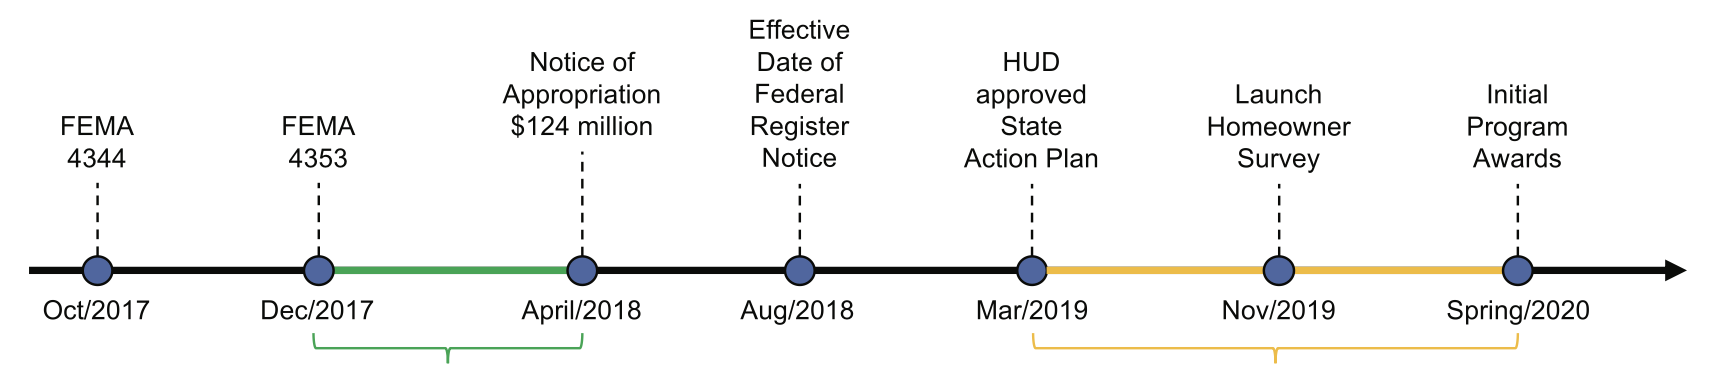

### <font color='orange'> CDBG-DR Homeowner Compensation Program Agent </font>



The Homeowner Compensation Program (HCP) is targeted at low-to-moderate income homeowners whose primary home is damaged by a disaster. These grants provide a limited amount of funding to support unmet housing needs, that is, losses that are not covered by insurance or SBA loans. Moreover, the total amount of funds allocated by HUD is limited. HUD calculates to expected federal assistance needed as

\begin{equation}
    S = \sum_{dc=3}^{5} H_{dc} \cdot M_{dc}
\end{equation}

where $S$ is the size of CDBG-DR HCP, $H_{dc}$ is the number of homeowners in each 'damage category' $dc$, and the multiplier $M_{dc}$ reflects the amount of unmet needs empirically estimated by HUD. HUD uses the FEMA Verified Losses to categorize each building as having (1) minor, (2) minor high, (3) major low, (4) major high, or (5) severe damage, and considers that only homes at major low, major high, or severe damage categories have unmet housing needs. The multipliers $M_{dc}$ are defined per state and per year. The default parameters in RAAbIT's implementation of the CDBG-DR Homeowner Compensation Program Agent are:

<br>

| Attribute | Explanation | Value | Source |
| ---       | ---         | ---   | ---    |
|T1 | Time from disaster to appropriation | 0.6 year | [Martin et al (2021)](https://www.tandfonline.com/doi/full/10.1080/10511482.2021.1875258)|
|T2 | Time from appropriation to allocation | 0.2 year| [Martin et al (2021)](https://www.tandfonline.com/doi/full/10.1080/10511482.2021.1875258)|
|T3 | Time from allocation to award | 0.2 year | [Martin et al (2021)](https://www.tandfonline.com/doi/full/10.1080/10511482.2021.1875258)|  
| T4 | Time from award to 1st expenditure | 0  | [Martin et al (2021)](https://www.tandfonline.com/doi/full/10.1080/10511482.2021.1875258) |
| T5 | Time 1st expenditure to completion | 1.9 years | [Martin et al (2021)](https://www.tandfonline.com/doi/full/10.1080/10511482.2021.1875258) |
| GrantCap | Maximum grant amount | $150,000 | [Fed. Register](https://www.govinfo.gov/content/pkg/FR-2018-08-14/pdf/2018-17365.pdf) |
| ProgramSize | Total allocated amount | Eq. | [Fed. Register](https://www.govinfo.gov/content/pkg/FR-2018-08-14/pdf/2018-17365.pdf) |



In [90]:
# HUD CDBGDR Homeowner Compensation Program
class RCDBGDRHomeownerCompensationProgram():
    _instances = set()

    '''
    Approval criteria:
        - CDBGDR funds are disbursed by state housing authorities prioritizing low-to-moderate households.
        - There is no clear criteria.
        - The amount of funding (called program size below) determines how many can receive assistance.
        - Setting size = large number is equivalent to assume CDBGDR funding will be available to all who need it.
        - The size of the program is defined based on the unmet housing needs. See https://onlinelibrary.wiley.com/doi/full/10.1111/risa.14206


    Amount:
        - Default grant cap is $150,000, as per HCD 2019 Action Plan, page 5.


    Disbursement time:
        - Model based on Understanding the Pace of HUD’s Disaster Housing Recovery Efforts by Carlos Martín, Daniel Teles & Nicole DuBois
          Disaster. -----------------3.8------------------ 0
                Appropriation. -----------3.2------------- 0.6  0.6
                      HUD Allocation ---------3.0--------- 0.8  0.2
                          HUD Award ------------2.8------- 1.0  0.2
                                1st expenditure ---2.1---- 1.7  0.7 **
                                          90% expenditure 3.8  2.1 [years]
    '''

    # Constructor
    def __init__(self,name,size=10**10,cap=150000,t1=0.6,t2=0.2,t3=0.2,t4=0,t5=1.9):
          self.object_name = name
          self._instances.add(weakref.ref(self))
          self.last_evaluation_time = 0
          self.program_size = size
          self.grant_cap = cap
          self.program_started = False
          self.funds_available = size
          self.resource_type = 'CDBGDRHCP'

          # Variables that define the program
          the_time_from_disaster_to_congressional_appropriation = t1 * 365
          the_time_from_appropriation_to_HUD_allocation = t2 * 365
          the_time_from_allocation_to_HUD_award = t3 * 365
          the_time_from_HUD_award_to_1st_expenditure = t4 * 365
          the_time_from_1st_expenditure_to_90_percent_expenditure = t5 * 365

          self.program_start_delay = the_time_from_disaster_to_congressional_appropriation + the_time_from_appropriation_to_HUD_allocation\
                                    + the_time_from_allocation_to_HUD_award + the_time_from_HUD_award_to_1st_expenditure
          self.program_duration = the_time_from_1st_expenditure_to_90_percent_expenditure



    # Destructor
    def __del__(self):
        pass
      #print('Destructor called.', self.object_name, 'deleted.')



    # Get instances
    @classmethod
    def get_instances(cls):
        dead = set()
        for ref in cls._instances:
            obj = ref()
            if obj is not None:
                yield obj
            else:
                dead.add(ref)
        cls._instances -= dead



    # Get object name
    def get_object_name(self):
        return self.object_name



    def reset_time(self):
        self.funds_available = self.program_size
        self.program_started = False



    # Program start delay
    def get_program_start_delay(self):
        return self.program_start_delay
    def set_program_start_delay(self,value):
        self.program_start_delay = value



    # Program duration
    def get_program_duration(self):
        return self.program_duration
    def set_program_duration(self,value):
        self.program_duration = value



    # Program size
    def get_program_size(self):
        return self.program_size
    def set_program_size(self,value):
        self.program_size = value


    # Simplified approach
    def get_CDBGDR_grant(self,balance):

        theAmount = 0
        theDelay = 0


        # Single-family Owner-occupied
        if self.funds_available > balance:
            # Define how much they will get
            theAmount = min(self.grant_cap,balance)

            # Define how long from now it will take for them to get the money
            theDelay = self.program_start_delay + rng.random() * self.program_duration

            # Reduce the pool of available funds accordingly
            self.funds_available -= theAmount

        return theAmount,theDelay

### <font color='orange'> CDBG-DR Small Rental Rehabilitation Program Agent </font>

The Small Rental Rehabilitation Program (SRRP) serves to rebuild affordable rental housing stock by rehabilitating small properties (typically 1 – 4 units) damaged in the disaster. These programs provide financial assistance, such as forgivable loans, to small rental property owners who serve a low to moderate income market. Such programs are appropriate in markets where a significant number of small rental property owners need assistance to bring their rental units back to the market. The program expands affordable rental options while also spurring economic growth by assisting landlords. In RAAbIT, the parameters needed to simulate the behaviors of the SRRP Agent are listed in Table below. The program size can be estimated using Eq. \eqref{eq:UHN} and replacing the number of homeowners per damage category, i.e., $H_{dc}$, with the number of rental units per damage category.


<br>

| Attribute | Explanation | Value | Source |
| ---       | ---         | ---   | ---    |
|T1 | Time from disaster to appropriation | 0.6 year | [Martin et al (2021)](https://www.tandfonline.com/doi/full/10.1080/10511482.2021.1875258)|
|T2 | Time from appropriation to allocation | 0.2 year| [Martin et al (2021)](https://www.tandfonline.com/doi/full/10.1080/10511482.2021.1875258)|
|T3 | Time from allocation to award | 0.2 year | [Martin et al (2021)](https://www.tandfonline.com/doi/full/10.1080/10511482.2021.1875258)|  
| T4 | Time from award to 1st expenditure | 1.75  | [Martin et al (2021)](https://www.tandfonline.com/doi/full/10.1080/10511482.2021.1875258)|
| T5 | Time 1st expenditure to completion | 1.25 years | [Martin et al (2021)](https://www.tandfonline.com/doi/full/10.1080/10511482.2021.1875258)|
| GrantCap | Maximum grant amount | $150,000 | [Fed. Register](https://www.govinfo.gov/content/pkg/FR-2018-08-14/pdf/2018-17365.pdf) |
| ProgramSize | Total allocated amount | Eq. | [Fed. Register](https://www.govinfo.gov/content/pkg/FR-2018-08-14/pdf/2018-17365.pdf) |


In [91]:
# CDBG-DR SRRP
class RCDBGDRSmallRentalRehabilitationProgram():
    _instances = set()

    '''
    Approval criteria:
        - CDBGDR funds are disbursed by state housing authorities prioritizing low-to-moderate households.
        - There is no clear criteria.
        - The amount of funding (called program size below) determines how many can receive assistance.
        - Setting size = large number is equivalent to assume CDBGDR funding will be available to all who need it.
        - The size of the program is defined based on the unmet housing needs. See https://onlinelibrary.wiley.com/doi/full/10.1111/risa.14206


    Amount:
        - Default grant cap is $150,000, as per HCD 2019 Action Plan, page 5.


    Disbursement time:
        - Model based on Understanding the Pace of HUD’s Disaster Housing Recovery Efforts by Carlos Martín, Daniel Teles & Nicole DuBois
          Disaster. -----------------3.8------------------ 0
                Appropriation. -----------3.2------------- 0.6  0.6
                      HUD Allocation ---------3.0--------- 0.8  0.2
                          HUD Award ------------2.8------- 1.0  0.2
                                1st expenditure ---2.1---- 1.7  0.7 **
                                          90% expenditure 3.8  2.1 [years]
    '''


    # Constructor
    def __init__(self,name,size=10**10,cap=150000,t1=0.6,t2=0.2,t3=0.2,t4=1.75,t5=1.9):
          self.object_name = name
          self._instances.add(weakref.ref(self))
          self.last_evaluation_time = 0

          self.program_size = size
          self.grant_cap = cap # SRR may need to set terms and funding amounts equivalent to the homeowner program (see link above)
          self.program_started = False
          self.funds_available = 0
          self.resource_type = 'CDBGDRSRR'


          # Variables that define the program
          the_time_from_disaster_to_congressional_appropriation = t1 * 365
          the_time_from_appropriation_to_HUD_allocation = t2 * 365
          the_time_from_allocation_to_HUD_award = t3 * 365
          the_time_from_HUD_award_to_1st_expenditure = t4 * 365
          the_time_from_1st_expenditure_to_90_percent_expenditure = t5 * 365

          self.program_start_delay = the_time_from_disaster_to_congressional_appropriation + the_time_from_appropriation_to_HUD_allocation\
                                    + the_time_from_allocation_to_HUD_award + the_time_from_HUD_award_to_1st_expenditure
          self.program_duration = the_time_from_1st_expenditure_to_90_percent_expenditure


    # Get instances
    @classmethod
    def get_instances(cls):
        dead = set()
        for ref in cls._instances:
            obj = ref()
            if obj is not None:
                yield obj
            else:
                dead.add(ref)
        cls._instances -= dead


    # Destructor
    def __del__(self):
        pass
      #print('Destructor called.', self.object_name, 'deleted.')



    # Get object name
    def get_object_name(self):
        return self.object_name



    def reset_time(self):
        self.funds_available = self.program_size
        self.program_started = False



    # Program start delay
    def get_program_start_delay(self):
        return self.program_start_delay
    def set_program_start_delay(self,value):
        self.program_start_delay = value



    # Program duration
    def get_program_duration(self):
        return self.program_duration
    def set_program_duration(self,value):
        self.program_duration = value



    # Program size
    def get_program_size(self):
        return self.program_size
    def set_program_size(self,value):
        self.program_size = value



    # Total loss in the community
    def set_total_loss(self,loss):
        self.funds_available = self.program_size * loss



    # Simplified approach
    def get_CDBGDR_grant(self, balance):
        theAmount = 0
        theDelay = 0

        if self.funds_available > balance:# and affordability == 'Yes':
            # Define how much they will get
            theAmount = min(self.grant_cap,balance)

            # Define how long from now it will take for them to get the money
            theDelay = self.program_start_delay + rng.random() * self.program_duration

            # Reduce the pool of available funds accordingly
            self.funds_available -= theAmount

        return theAmount,theDelay

## <font color='orange'> Household Agent </font>

There are multiple metrics of post-disaster recovery. RAAbIT simulates the recovery of housing units. That is, RAAbIT simulates the processes thata building goes through between being damaged by a disaster and being fully recovered. The occupants of the building are simulated only to the extent that they affect the building recovery, e.g., their ability to finance repairs. RAAbIT does not simulate the movements of displaced households between, emergency shelter, temporary shelter, or temporary housing (e.g., see [Sutley and Hamideh (2020)](https://onlinelibrary.wiley.com/doi/full/10.1111/risa.13576)). Future implementations may expand the current scope.


<br>

**Building occupancy**: the definition of single-family and multi-family is based on the number of units within a building. That is, a building with more than one unit is considered multi-family. Thus, multi-family buildings include duplexes, triplexes, and apartment buildings.

**Building tenure**: buildings may be occupied by their owners or rented to tenants by a landlord (i.e., building owner). However, renters do not have agency over recovery. Thus, decisions regarding the building repairs are only made by the occupants of the building if the building is owner-occupied. Single-family owner-occupied have a single household associated with them.In multi-family owner-occupied buildings (i.e., condominiums) each unit is owner by its occupants but public areas are jointly owned. Single-family renter-occupied buildings have an owner and a tenant. Multi-family renter-occupied buildings (i.e., apartment buildings) are assumed to be owned by a company and occupied by multiple tenants.

The Building Agents have multiple attributes df_main


**Building Attributes**


| Attribute | Explanation | Value or Metric |
| ---       | ---         | ---   |
|DamageState| Hazus-based damage state | [0,4] |
|repair_cost | Repair cost | $ |
|RepairTime | Repair time | days |
|TimeUnderRepair | Days since a contractor arrived | days |
|Functionality | TimeUnderRepair/RepairTime  | [0,1]|
|ExpectedFunds | Total funding expected over time | [0,repair_cost] |
|AvailableFunds | Funding available at *t* | [0,repair_cost] |
|UnmetFinancialNeeds | repair_cost - ExpectedFunds | [0,repair_cost] |
|DelayToMakeDecision | Time between event and finance procurement | days |
|RecoveryTime | Time between event and Functionality = 1 | days |

<br>

**Financing-related variables**

| Attribute | Explanation | Value or Metric |
| ---       | ---         | ---   |
|FundingDelay | Time between event and all funding received | days |
|FundingDelayChain | Funding delay imposed by landlord decisions | days |
|amount_from_insurance | amount obtained from source | \$ |
|amount_from_bank | amount obtained from source | \$ |
|amount_from_FEMA | amount obtained from source | \$ |
|amount_from_SBA | amount obtained from source | \$ |
|amount_from_CDBGDR | amount obtained from source | \$ |
|amount_from_savings | amount obtained from source | \$ |
|time_for_insurance | time when funding from source is received | days|
|time_for_Bank | time when funding from source is received | days|
|time_for_FEMA | time when funding from source is received | days|
|time_for_public_loan | time when funding from source is received | days|
|time_for_CDBGDR | time when funding from source is received | days|
|time_for_savings | time when funding from source is received | days|


<br>

**Service-related variables**

| Attribute | Explanation | Value or Metric |
| ---       | ---         | ---   |
|contractors_on_site | Number of contractor crews working on repairs | [0,number of units] |
|contractor_origin | Agent that provided contractors | An agent |
|already_requested_engineering_assessment | As name suggests | True/False |
|already_requested_contractors | As name suggests | True/False |
|already_received_engineering_assessment | As name suggests | True/False |
|already_received_contractors | As name suggests | True/False |


In [92]:
class RHousehold():
    _instances = set()

    # Constructor
    def __init__(self,name,
                ol = 'Minimum',
                income = 0,
                tenure = 'owner_occupied',
                delay_mode = 'None',
                insurance = False,
                fema_prob = 0,
                sba_prob = 0,
                insurer = '',
                banker = '',
                loaner = '',
                fema_granter = '',
                hud_granter = '',
                engineer = '',
                permit = '',
                m_eqt = 1,
                building = ''
                ):


        self._instances.add(weakref.ref(self))
        self.output_level = ol
        self.last_evaluation_time = 0
        self.evaluate = False

        # Homeowner characteristics
        self.object_name = name
        self.homeowner_income = income
        self.tenure = tenure
        self.delay_mode = delay_mode
        self.insurance = insurance
        self.FEMA_application = fema_prob
        self.SBA_application = sba_prob
        self.current_location = 'at home'
        self.my_building = building


        self.homeowner_income_bracket = 'Low' if income < 0.8*ami else ('High' if income > 1.2*ami else 'Moderate')
        self.savings =  2.3 * rng.choice(a=[0,10000],p=[1-0.07,0.07]) + 2 * rng.choice(a=[0,22000],p=[1-0.17,0.17])  if income < 27030 else (
                        2.3 * rng.choice(a=[0,19000],p=[1-0.15,0.15]) + 2 * rng.choice(a=[0,25000],p=[1-0.45,0.45]) if income < 52180 else (
                        2.3 * rng.choice(a=[0,20000],p=[1-0.22,0.22]) + 2 * rng.choice(a=[0,40000],p=[1-0.64,0.64]) if income < 85080 else (
                        2.3 * rng.choice(a=[0,21000],p=[1-0.31,0.31]) + 2 * rng.choice(a=[0,74000],p=[1-0.79,0.79]) if income < 141110 else 2.3 * rng.choice(a=[0,75200],p=[1-0.51,0.51]) + 2 * rng.choice(a=[0,220000],p=[1-0.9,0.9])
                        )))
        self.savings *= 1.0

                        # https://www.census.gov/data/tables/2020/demo/wealth/wealth-asset-ownership.html
        self.equity =  2 * rng.choice(a=[0,100000],p=[1-0.37,0.37]) + 2.38 * rng.choice(a=[0,140000],p=[1-0.02,0.02]) + 2 * rng.choice(a=[0,38800],p=[1-0.02,0.02]) if income < 27030 else (
                        2 * rng.choice(a=[0,120000],p=[1-0.53,0.53]) + 2.38 * rng.choice(a=[0,110000],p=[1-0.04,0.04]) + 2 * rng.choice(a=[0,55000],p=[1-0.05,0.05]) if income < 52180 else (
                        2 * rng.choice(a=[0,130000],p=[1-0.62,0.62]) + 2.38 * rng.choice(a=[0,105000],p=[1-0.05,0.05]) + 2 * rng.choice(a=[0,50000],p=[1-0.07,0.07]) if income < 85080 else (
                        2 * rng.choice(a=[0,150000],p=[1-0.74,0.74]) + 2.38 * rng.choice(a=[0,156000],p=[1-0.08,0.08]) + 2 * rng.choice(a=[0,70000],p=[1-0.1,0.1])   if income < 141110 else 2 * rng.choice(a=[0,218000],p=[1-0.83,0.83]) + 2.38 * rng.choice(a=[0,226000],p=[1-0.15,0.15]) + 2 * rng.choice(a=[0,120000],p=[1-0.17,0.17])
                      )))  # https://www.census.gov/data/tables/2020/demo/wealth/wealth-asset-ownership.html

        self.equity *= m_eqt


        # Agent suppliers
        self.insurance_company = insurer
        self.bank = banker
        self.FEMA = fema_granter
        self.SBA = loaner
        self.CDBGDR = hud_granter
        self.my_permit_assessor = permit
        self.my_engineering_firm = engineer
        self.already_requested_engineering_assessment = False
        self.already_received_engineering_assessment = False


        # Supply variables
        self.delay_permit = 0
        self.already_requested_engineering_assessment = False
        self.already_requested_contractors = False
        self.already_received_engineering_assessment = False
        self.already_received_contractors = False


        # Funding per source
        self.funding_delay = 0
        self.delay_to_make_decision = np.random.lognormal(np.log(180), 1) if self.delay_mode == 'Lognormal' else 0
        self.amount_from_savings = 0
        self.amount_from_insurance = 0
        self.amount_from_bank = 0
        self.amount_from_FEMA = 0
        self.amount_from_SBA = 0
        self.amount_from_CDBGDR = 0
        self.time_for_insurance = 0
        self.time_for_Bank = 0
        self.time_for_FEMA = 0
        self.time_for_public_loan = 0
        self.time_for_CDBGDR = 0
        self.time_for_savings = 0
        self.expected_funds = 0
        self.available_funds = 0
        self.unmet_financial_needs = 0
        self.recovery_time = np.NaN


    # Destructor
    def __del__(self):
        if self.output_level == 'Maximum':
            pass
            #print('Destructor called.', self.object_name, 'deleted.')


    # Get instances
    @classmethod
    def get_instances(cls):
        dead = set()
        for ref in cls._instances:
            obj = ref()
            if obj is not None:
                yield obj
            else:
                dead.add(ref)
        cls._instances -= dead


    # Reset variables
    def reset_time(self):

        # Homeowner characteristics
        self.current_location = 'at home'


        # Building properties
        self.evaluate = False
        self.expected_funds = 0
        self.available_funds = 0
        self.unmet_financial_needs = 0
        self.recovery_time = np.NaN
        self.delay_to_make_decision = np.random.lognormal(np.log(180), 1) if self.delay_mode == 'Lognormal' else 0


        # Supply variables
        self.delay_permit = 0
        self.already_requested_engineering_assessment = False
        self.already_requested_contractors = False
        self.already_received_engineering_assessment = False
        self.already_received_contractors = False


        # Funding per source
        self.amount_from_insurance = 0
        self.amount_from_bank = 0
        self.amount_from_FEMA = 0
        self.amount_from_SBA = 0
        self.amount_from_CDBGDR = 0
        self.time_for_insurance = 0
        self.time_for_Bank = 0
        self.time_for_FEMA = 0
        self.time_for_public_loan = 0
        self.time_for_CDBGDR = 0
        self.time_for_savings = 0
        self.expected_funds = 0
        self.available_funds = 0
        self.unmet_financial_needs = 0
        self.recovery_time = np.NaN

        self.last_evaluation_time = 0



    # Seek funding from different sources
    def seek_funds(self,my_unmet_financial_needs):

        funding_delay = 0

        if self.tenure == 'owner_occupied':

            # High-income homeowner:
            if self.homeowner_income_bracket == 'High':

                # Get funding from insurance
                if self.insurance == True and self.insurance_company != 'None':
                    theamount_from_insurance,delay_from_insurance = self.insurance_company.get_insurance_payment(my_unmet_financial_needs,self.my_building.replacement_cost)
                    my_unmet_financial_needs -= theamount_from_insurance
                    funding_delay += delay_from_insurance
                    self.time_for_insurance = funding_delay
                    self.amount_from_insurance += theamount_from_insurance

                # Get funding from SBA
                if my_unmet_financial_needs > 0 and self.SBA != 'None' and rng.random() < self.SBA_application:
                    amount_from_SBA,delay_from_SBA = self.SBA.get_SBA_loan(self.tenure,self.my_building.repair_cost,my_unmet_financial_needs)
                    my_unmet_financial_needs -= amount_from_SBA
                    funding_delay += delay_from_SBA
                    self.time_for_public_loan = funding_delay
                    self.amount_from_SBA += amount_from_SBA
                    self.equity = max(0,self.equity - amount_from_SBA)

                # Use savings
                self.amount_from_savings = max(my_unmet_financial_needs-self.savings,0)
                my_unmet_financial_needs = max(my_unmet_financial_needs-self.amount_from_savings,0)

                # Get funding from Bank
                if my_unmet_financial_needs > 0 and self.bank != 'None':
                    amount_from_bank,delay_from_bank = self.bank.get_private_loan(self.homeowner_income,self.tenure,self.equity,self.my_building.home_value,self.my_building.repair_cost,my_unmet_financial_needs)
                    my_unmet_financial_needs -= amount_from_bank
                    funding_delay += delay_from_bank
                    self.time_for_Bank = funding_delay
                    self.amount_from_bank += amount_from_bank
                    self.equity = max(0,self.equity - amount_from_bank)


            # Moderate-income homeowner:
            # Note, low and moderate income homeowners go through similar processes with different % of receiving money
            # Note 2: not considering NGO funding here
            elif self.homeowner_income_bracket == 'Moderate' or self.homeowner_income_bracket == 'Low':

                # Get funding from insurance
                if self.insurance == True and self.insurance_company != 'None':
                    theamount_from_insurance,delay_from_insurance = self.insurance_company.get_insurance_payment(my_unmet_financial_needs,self.my_building.replacement_cost)
                    my_unmet_financial_needs -= theamount_from_insurance
                    funding_delay += delay_from_insurance
                    self.time_for_insurance = funding_delay
                    self.amount_from_insurance += theamount_from_insurance

                # Get funding from SBA
                if my_unmet_financial_needs > 0 and self.SBA != 'None' and rng.random() < self.SBA_application:
                    amount_from_SBA,delay_from_SBA = self.SBA.get_SBA_loan(self.tenure,self.my_building.repair_cost,my_unmet_financial_needs)
                    my_unmet_financial_needs -= amount_from_SBA
                    funding_delay += delay_from_SBA
                    self.time_for_public_loan = funding_delay
                    self.amount_from_SBA += amount_from_SBA
                    self.equity = max(0,self.equity - amount_from_SBA)

                # Get funding from FEMA IAP
                if my_unmet_financial_needs > 0 and self.FEMA != 'None' and rng.random() < self.FEMA_application:
                    amount_from_FEMA,delay_from_FEMA = self.FEMA.get_FEMA_grant(self.homeowner_income_bracket,'House/Duplex',self.insurance,self.my_building.repair_cost,my_unmet_financial_needs)
                    my_unmet_financial_needs -= amount_from_FEMA
                    funding_delay += delay_from_FEMA
                    self.time_for_FEMA = funding_delay
                    self.amount_from_FEMA += amount_from_FEMA

                # Use savings
                self.amount_from_savings = max(my_unmet_financial_needs-self.savings,0)
                my_unmet_financial_needs = max(my_unmet_financial_needs-self.amount_from_savings,0)

                # Get funding from Bank
                if my_unmet_financial_needs > 0 and self.bank != 'None':
                    amount_from_bank,delay_from_bank = self.bank.get_private_loan(self.homeowner_income,self.tenure,self.equity,self.my_building.home_value,self.my_building.repair_cost,my_unmet_financial_needs)
                    my_unmet_financial_needs -= amount_from_bank
                    funding_delay += delay_from_bank
                    self.time_for_Bank = funding_delay
                    self.amount_from_bank += amount_from_bank
                    self.equity = max(0,self.equity - amount_from_bank)

                # Apply for a CDBGDR Grant, if still needed
                if my_unmet_financial_needs > 0 and self.CDBGDR != 'None':
                    amount_from_CDBGDR,delay_from_CDBGDR = self.CDBGDR.get_CDBGDR_grant(my_unmet_financial_needs)
                    my_unmet_financial_needs -= amount_from_CDBGDR
                    funding_delay += delay_from_CDBGDR
                    self.time_for_CDBGDR = delay_from_CDBGDR
                    self.amount_from_CDBGDR += amount_from_CDBGDR

            else:
                print(self.object_name,'cannot identify this homeowners income bracket',self.homeowner_income_bracket)

        # Renter-occupied housing
        elif self.tenure == 'renter_occupied':

            # Get funding from insurance
            if self.insurance == True and self.insurance_company != 'None':
                theamount_from_insurance,delay_from_insurance = self.insurance_company.get_insurance_payment(my_unmet_financial_needs,self.my_building.replacement_cost)
                my_unmet_financial_needs -= theamount_from_insurance
                funding_delay += delay_from_insurance
                self.time_for_insurance = funding_delay
                self.amount_from_insurance += theamount_from_insurance

            # Get funding from SBA
            if my_unmet_financial_needs > 0 and self.SBA != 'None' and rng.random() < self.SBA_application:
                amount_from_SBA,delay_from_SBA = self.SBA.get_SBA_loan(self.tenure,self.my_building.repair_cost,my_unmet_financial_needs)
                my_unmet_financial_needs -= amount_from_SBA
                funding_delay += delay_from_SBA
                self.time_for_public_loan = funding_delay
                self.amount_from_SBA += amount_from_SBA
                self.equity = max(0,self.equity - amount_from_SBA)

            # Use savings
            self.amount_from_savings = max(my_unmet_financial_needs-self.savings,0)
            my_unmet_financial_needs = max(my_unmet_financial_needs-self.amount_from_savings,0)

            # Get funding from Bank
            if my_unmet_financial_needs > 0 and self.bank != 'None':
                amount_from_bank,delay_from_bank = self.bank.get_private_loan(self.homeowner_income,self.tenure,self.equity,self.my_building.home_value,self.my_building.repair_cost,my_unmet_financial_needs)
                my_unmet_financial_needs -= amount_from_bank
                funding_delay += delay_from_bank
                self.time_for_Bank = funding_delay
                self.amount_from_bank += amount_from_bank
                self.equity = max(0,self.equity - amount_from_bank)

        self.expected_funds = self.my_building.repair_cost - my_unmet_financial_needs + 1

        if my_unmet_financial_needs > 0:
            self.funding_delay = np.NaN
            # print('funding_delay:',funding_delay)

        else:
            self.funding_delay = funding_delay



    # Collect supplies delivered
    def set_delivery(self,amount,theType):

        if theType == 'EngineeringAssessment':
            self.evaluate = True
            self.already_received_engineering_assessment = True



    def step(self,t):
        # This is the main class function for this class
        # It is called on every time step
        if self.output_level == 'Maximum':
            print('Evaluating model',self.get_object_name())



        # If this is the first time step define a few variables
        if t == 0:
            # reset all variables
            self.reset_time()
            self.my_building.reset_time()



        if t == 0:
            # Funds - check if the homeowner has obtained funds, if not, request
            # The amount of funds missing at time t

            # If damage is minor (self.repair_time <= 30 means DS <=2)
            if self.my_building.repair_time <= 30:
                self.funding_delay = 0
                self.expected_funds = self.my_building.repair_cost
                self.unmet_financial_needs = self.my_building.repair_cost - self.expected_funds


            # If damage state is severe or complete
            else:
                self.current_location = 'displaced'
                my_unmet_financial_needs = self.my_building.repair_cost - self.available_funds

                # Funding
                if my_unmet_financial_needs > 0 and self.expected_funds == 0:
                    self.seek_funds(my_unmet_financial_needs)
                    self.unmet_financial_needs = self.my_building.repair_cost - self.expected_funds



        # Get hold of the buildings that need to be evaluated in this time step
        # If the building is not functional still, evaluate it
        if self.current_location != 'at home':

            # When will funds be available?
            if t >= self.funding_delay:
                self.available_funds = self.expected_funds
                self.delay_permit = self.my_permit_assessor.get_permitdelay() # apply for permit once funds are available


            # Engineering assessment
            if  t >= self.delay_to_make_decision + self.funding_delay + self.delay_permit\
                and self.already_requested_engineering_assessment == False\
                and self.my_engineering_firm != 'None':

                # Make an engineering assessment request
                df_request = pd.DataFrame([[self,'EngineeringAssessment',1,10]], columns=['Requester','Type','Amount','Bid'])
                self.my_engineering_firm.set_request(df_request)
                self.already_requested_engineering_assessment = True # Make sure this building will not request this resource anymore

                if self.output_level == 'Maximum':
                    print(self.get_object_name(),'building is making a request for engineering assessment to',self.my_engineering_firm,'who now has',self.my_engineering_firm.df_requests.shape,'requests at time',t)


            # Read to get contractor
            if  self.available_funds >= self.my_building.repair_cost\
                and self.already_received_engineering_assessment == True\
                and self.already_requested_contractors == False:

                    # Add building to list of requesters
                    self.my_building.seek_contractor()
                    self.already_requested_contractors = True


            # Check if repaired
            if self.my_building.rebuild_step(t - self.last_evaluation_time):
                self.recovery_time = t
                self.current_location = 'at home'

        self.last_evaluation_time = t

## <font color='orange'> Single-family Building Agent </font>


In [93]:
class RSingleFamilyBuilding():

    _instances = set()

    # Constructor
    def __init__(self,name,ol,lat,lon,neighbors,value,replacement,repair_cost,repair_time):

        self._instances.add(weakref.ref(self))
        self.last_evaluation_time = 0

        self.object_name = name
        self.output_level = ol
        self.home_value = value
        self.replacement_cost = replacement
        self.repair_cost = repair_cost
        self.repair_time = repair_time
        self.functionality = 0 if self.repair_time > 0 else 1


        # Building properties
        self.latitude = lat
        self.longitude = lon
        self.evaluate = False
        self.time_under_repairs = 0
        self.recovery_time = np.NaN
        self.neighbors = neighbors


        # Supply variables
        self.my_contractor = ''
        self.already_requested_contractors = False
        self.already_received_contractors = False
        self.contractors_on_site = 0
        self.is_seeking_contractors = False


        '''
        Demands
        '''
        self.water_demand = 0
        self.power_demand = 0


    # Destructor
    def __del__(self):
        if self.output_level == 'Maximum':
            pass
            #print('Destructor called.', self.object_name, 'deleted.')


    # Get instances
    @classmethod
    def get_instances(cls):
        dead = set()
        for ref in cls._instances:
            obj = ref()
            if obj is not None:
                yield obj
            else:
                dead.add(ref)
        cls._instances -= dead


    # Reset variables
    def reset_time(self):

        # Building properties
        self.evaluate = False
        self.functionality = 0 if self.repair_time > 0 else 1
        self.time_under_repairs = 0
        self.recovery_time = np.NaN


        # Supply variables
        self.my_contractor = ''
        self.funding_delay = 0
        self.contractors_on_site = 0
        self.is_seeking_contractors = False


    # Get object name
    def get_object_name(self):
        return self.object_name

    def seek_contractor(self):
        self.is_seeking_contractors = True


    def assign_contractor(self, contractor):
      self.my_contractor = contractor
      self.contractors_on_site = 1
      self.is_seeking_contractors = False
      #print('received contractor',self.object_name)


    def rebuild_step(self,dt):
        # This is the main class function for this class
        # It is called on every time step
        if self.output_level == 'Maximum':
            print('Evaluating model',self.get_object_name())


        # If repairs are progressing normally
        if self.contractors_on_site > 0 and self.functionality < 1.0:

            # Power demand
            self.power_demand = 1

            # If this building has a contractor, add dt to its time under repairs
            self.time_under_repairs += dt
            self.functionality = min(1.0,self.time_under_repairs/(self.repair_time + 10**-8))

            if self.output_level == 'Maximum':
                print('Repairs are progressing at building. The building functionality is:',self.functionality)

            return False


        # If the building just completed repairs
        elif self.contractors_on_site > 0 and self.functionality >= 1:

            # Power demand
            self.power_demand = 2

            if self.output_level == 'Maximum':
                print('Repairs completed at buildings',self.object_name)

            # Check where the contractors came from and return them to the object that owns them
            self.my_contractor.dismiss()

            # Remove the contractors from this building
            self.contractors_on_site = 0

            return True


    # Recovery curves
    def get_recovered(self):
        return self.functionality


    # Displacement curves
    def get_displaced(self):
        return self.household_size if self.functionality < 1 else 0


    # Workforce demand curves
    def get_under_repairs(self):
        return self.contractors_on_site

## <font color='orange'> Exposure Modelling </font>

Based on Hazus Inventory Technical Manual - Hazus 4.2 Service Pack 3

In [94]:
class exposure_simulator():

    def __init__(self, portfolio = '', census_region = 'West', state_code = 'CA', county_code = '', inc_ratio = 1, ref_year = 2020):

        # Inputs
        self.path = filepath
        self.census_region = census_region
        self.state_code = state_code
        self.county_code = county_code
        self.income_ratio = inc_ratio
        self.reference_year = ref_year

        # Internal variables
        self.nblds = 1
        self.portfolio = portfolio


    # From Hazus Inventory Technical Manual Section
    def setConstructionClassFromHazus(self,input_df):
        # region: location in the US
        # ir: income ration

        s = ['Luxury','Custom','Average','Economic']
        p = []
        v = ['None'] * len(input_df.index)

        for i in range(len(input_df)):

            if self.income_ratio < 0.5:
                p = [0,0,0,1]

            elif 0.5 <= self.income_ratio < 0.85:
                p = [0,0,0.25,0.75]

            elif 0.85 <= self.income_ratio < 1.25:
                p = [0,0.25,0.75,0]

            elif 1.25 <= self.income_ratio < 2.0:
                p = [0,1,0,0]

            else:
                p = [1,0,0,0]

            v[i] = rng.choice(s, p=p, size=1, replace=True)[0]

        return v


    # Number of stories
    def setStoriesFromHazus(self,input_df):
        # From Section 5.5.6 in the Hazus Inventory Technical Manual
        # region: Northeast, Midwest, South, or West
        # occupancy: RES1 for detached buildings, RES3A and RES3B for duplexes and triplexes
        # n: number of buildings

        # The number of stories is defined according to the Hazus Inventory Manual
        # Values from Table 5-4 Hazus Inventory manual
        s_stories = []
        p_stories = []
        v = [0] * len(input_df.index)

        for i in range(len(input_df.index)):

            occupancy = input_df.loc[i,'Occupancy']

            if occupancy == 'RES1':
                if self.census_region == 'Northeast':
                    s_stories = [1, 2, 3]
                    p_stories = [0.25,0.68,0.05]

                elif self.census_region == 'Midwest':
                    s_stories = [1, 2, 3]
                    p_stories = [0.50,0.46,0.02]

                elif self.census_region == 'South':
                    s_stories = [1, 2, 3]
                    p_stories = [0.66,0.32,0.01]

                else: # West
                    s_stories = [1, 2, 3]
                    p_stories = [0.66,0.30,0.02]

                p_stories = [float(i)/sum(p_stories) for i in p_stories]
                v[i] = rng.choice(s_stories, p=p_stories, size=1, replace=True)[0]

            # RES3 building fall into two categories 1-2, and 3-4 stories
            else:
                if self.census_region == 'Northeast':
                    s_stories = [1,3]
                    p_stories = [0.29,0.26]

                elif self.census_region == 'Midwest':
                    s_stories = [1,3]
                    p_stories = [0.49,0.29]

                elif self.census_region == 'South':
                    s_stories = [1,3]
                    p_stories = [0.66,0.21]

                else: # West
                    s_stories = [1,3]
                    p_stories = [0.58,0.25]

                p_stories = [float(i)/sum(p_stories) for i in p_stories]
                v[i] = int(rng.choice(s_stories, p=p_stories, size=1, replace=True)[0] + round(rng.random()))

        return v



    # Basement flag
    def setBasementFromHazus(self,n):
        # From Tables 5-3 and 5-6 in the Hazus Inventory Technical Manual
        # region: region in the United States
        # n: number of buildings
        s = [True, False]
        p = []

        if self.census_region == 'New England':
            p = [0.72,0.28]

        elif self.census_region == 'Mid Atlantic':
            p = [0.58,0.42]

        elif self.census_region == 'East North Central':
            p = [0.57,0.42]

        elif self.census_region == 'West North Central':
            p = [0.56,0.44]

        elif self.census_region == 'South Atlantic':
            p = [0.19,0.81]

        elif self.census_region == 'East South Central':
            p = [0.18,0.82]

        elif self.census_region == 'West South Central':
            p = [0.02,0.98]

        elif self.census_region == 'Mountain':
            p = [0.26,0.74]

        else: # West
            p = [0.08, 0.92]

        p = [float(i)/sum(p) for i in p]
        return rng.choice(s, p=p, size=n, replace=True)



    # Area
    def setAreaFromHazus(self,df_input):
        # From Table 5-2 in the Hazus Inventory Technical Manual
        # n: number of buildings
        # bsm: presence of basement, True or False
        # occ: occupancy
        # units: number of units in multi-unit buildings

        n = len(df_input.index)
        bsm = df_input['Basement']
        occ = df_input['Occupancy']
        units = df_input['Units']
        area = [0] * n

        for i in range(n):
            if occ[i] == 'RES1':
                if self.census_region == 'New England':
                    if self.income_ratio < 0.5:
                        if bsm[i] == False:
                            area[i] = 1300
                        else:
                            area[i] = 975

                    elif 0.5 <= self.income_ratio < 0.85:
                        if bsm[i] == False:
                            area[i] = 1500
                        else:
                            area[i] = 1125

                    elif 0.85 <= self.income_ratio < 1.25:
                        if bsm[i] == False:
                            area[i] = 1800
                        else:
                            area[i] = 1350

                    elif 1.25 <= self.income_ratio < 2:
                        if bsm[i] == False:
                            area[i] = 1900
                        else:
                            area[i] = 1425

                    else:
                        if bsm[i] == False:
                            area[i] = 2200
                        else:
                            area[i] = 1650

                elif self.census_region == 'Middle Atlantic':
                    if self.income_ratio < 0.5:
                        if bsm[i] == False:
                            area[i] = 1300
                        else:
                            area[i] = 975

                    elif 0.5 <= self.income_ratio < 0.85:
                        if bsm[i] == False:
                            area[i] = 1500
                        else:
                            area[i] = 1125

                    elif 0.85 <= self.income_ratio < 1.25:
                        if bsm[i] == False:
                            area[i] = 1700
                        else:
                            area[i] = 1275

                    elif 1.25 <= self.income_ratio < 2:
                        if bsm[i] == False:
                            area[i] = 1900
                        else:
                            area[i] = 1425

                    else:
                        if bsm[i] == False:
                            area[i] = 2200
                        else:
                            area[i] = 1650

                elif self.census_region == 'East North Central':
                    if self.income_ratio < 0.5:
                        if bsm[i] == False:
                            area[i] = 1300
                        else:
                            area[i] = 975

                    elif 0.5 <= self.income_ratio < 0.85:
                        if bsm[i] == False:
                            area[i] = 1600
                        else:
                            area[i] = 1200

                    elif 0.85 <= self.income_ratio < 1.25:
                        if bsm[i] == False:
                            area[i] = 1700
                        else:
                            area[i] = 1275

                    elif 1.25 <= self.income_ratio < 2:
                        if bsm[i] == False:
                            area[i] = 1800
                        else:
                            area[i] = 1350

                    else:
                        if bsm[i] == False:
                            area[i] = 2500
                        else:
                            area[i] = 1875

                elif self.census_region == 'West North Central':
                    if self.income_ratio < 0.5:
                        if bsm[i] == False:
                            area[i] = 1300
                        else:
                            area[i] = 975

                    elif 0.5 <= self.income_ratio < 0.85:
                        if bsm[i] == False:
                            area[i] = 1500
                        else:
                            area[i] = 1125

                    elif 0.85 <= self.income_ratio < 1.25:
                        if bsm[i] == False:
                            area[i] = 1800
                        else:
                            area[i] = 1350

                    elif 1.25 <= self.income_ratio < 2:
                        if bsm[i] == False:
                            area[i] = 1800
                        else:
                            area[i] = 1350

                    else:
                        if bsm[i] == False:
                            area[i] = 2300
                        else:
                            area[i] = 1725

                elif self.census_region == 'South Atlantic':
                    if self.income_ratio < 0.5:
                        if bsm[i] == False:
                            area[i] = 1400
                        else:
                            area[i] = 1050

                    elif 0.5 <= self.income_ratio < 0.85:
                        if bsm[i] == False:
                            area[i] = 1600
                        else:
                            area[i] = 1200

                    elif 0.85 <= self.income_ratio < 1.25:
                        if bsm[i] == False:
                            area[i] = 1700
                        else:
                            area[i] = 1275

                    elif 1.25 <= self.income_ratio < 2:
                        if bsm[i] == False:
                            area[i] = 2000
                        else:
                            area[i] = 1500

                    else:
                        if bsm[i] == False:
                            area[i] = 2300
                        else:
                            area[i] = 1725

                if self.census_region == 'East South Central':
                    if self.income_ratio < 0.5:
                        if bsm[i] == False:
                            area[i] = 1300
                        else:
                            area[i] = 975

                    elif 0.5 <= self.income_ratio < 0.85:
                        if bsm[i] == False:
                            area[i] = 1400
                        else:
                            area[i] = 1050

                    elif 0.85 <= self.income_ratio < 1.25:
                        if bsm[i] == False:
                            area[i] = 1700
                        else:
                            area[i] = 1275

                    elif 1.25 <= self.income_ratio < 2:
                        if bsm[i] == False:
                            area[i] = 1900
                        else:
                            area[i] = 1425

                    else:
                        if bsm[i] == False:
                            area[i] = 2500
                        else:
                            area[i] = 1875

                if self.census_region == 'West South Central':
                    if self.income_ratio < 0.5:
                        if bsm[i] == False:
                            area[i] = 1300
                        else:
                            area[i] = 975

                    elif 0.5 <= self.income_ratio < 0.85:
                        if bsm[i] == False:
                            area[i] = 1700
                        else:
                            area[i] = 1275

                    elif 0.85 <= self.income_ratio < 1.25:
                        if bsm[i] == False:
                            area[i] = 1800
                        else:
                            area[i] = 1350

                    elif 1.25 <= self.income_ratio < 2:
                        if bsm[i] == False:
                            area[i] = 1900
                        else:
                            area[i] = 1425

                    else:
                        if bsm[i] == False:
                            area[i] = 2500
                        else:
                            area[i] = 1875

                elif self.census_region == 'Mountain':
                    if self.income_ratio < 0.5:
                        if bsm[i] == False:
                            area[i] = 1200
                        else:
                            area[i] = 900

                    elif 0.5 <= self.income_ratio < 0.85:
                        if bsm[i] == False:
                            area[i] = 1500
                        else:
                            area[i] = 1125

                    elif 0.85 <= self.income_ratio < 1.25:
                        if bsm[i] == False:
                            area[i] = 1700
                        else:
                            area[i] = 1275

                    elif 1.25 <= self.income_ratio < 2:
                        if bsm[i] == False:
                            area[i] = 1800
                        else:
                            area[i] = 1350

                    else:
                        if bsm[i] == False:
                            area[i] = 2600
                        else:
                            area[i] = 1950

                else: # West
                    if self.income_ratio < 0.5:
                        if bsm[i] == False:
                            area[i] = 1300
                        else:
                            area[i] = 975

                    elif 0.5 <= self.income_ratio < 0.85:
                        if bsm[i] == False:
                            area[i] = 1500
                        else:
                            area[i] = 1125

                    elif 0.85 <= self.income_ratio < 1.25:
                        if bsm[i] == False:
                            area[i] = 1700
                        else:
                            area[i] = 1275

                    elif 1.25 <= self.income_ratio < 2:
                        if bsm[i] == False:
                            area[i] = 1900
                        else:
                            area[i] = 1425

                    else:
                        if bsm[i] == False:
                            area[i] = 2100
                        else:
                            area[i] = 1575

            elif occ[i] == 'RES3A' or occ[i] == 'RES3B':

                if self.census_region == 'Northeast':
                    area[i] = 1191 * units[i]
                elif self.census_region == 'Midwest':
                    area[i] = 1279 * units[i]
                elif self.census_region == 'South':
                    area[i] = 945 * units[i]
                else: #West
                    area[i] = 930 * units[i]

            else: #RES3C-RES3F
                if self.census_region == 'Northeast':
                    area[i] = 849 * units[i]
                elif self.census_region == 'Midwest':
                    area[i] = 787 * units[i]
                elif self.census_region == 'South':
                    area[i] = 916 * units[i]
                else: #West
                    area[i] = 811 * units[i]

        return area


    # Replacement cost
    def setreplacement_costFromHazus(self,input_df):
        # From Section 5.9.2 in the Hazus Inventory Technical Manual
        # Assumption
        bsm_finish = True

        v = [0] * len(input_df.index)

        for i in range(len(input_df.index)):

            bld_occ     = input_df.loc[i,'Occupancy']
            const_class = str(input_df.loc[i,'ConstructionClass'])
            bld_area    = input_df.loc[i,'Area']
            n_storeys   = input_df.loc[i,'Stories']
            bsm_flag    = input_df.loc[i,'Basement']

            bsm_area = 0.0
            if (bsm_flag == True):
                bsm_area = bld_area * 0.25


            # Adapted from Building Portfolio Manual Table 6.3
            bld_value = 0.0
            if (bld_occ == 'RES1'):
                if (const_class == 'Economic'):
                    if n_storeys == 1:
                        bld_value = 97.61 * bld_area + 26.45 * bsm_area if bsm_finish == True else 9.55 * bsm_area
                    elif n_storeys == 2:
                        bld_value = 104.04 * bld_area + 15.20 * bsm_area if bsm_finish == True else 6.30 * bsm_area
                    elif n_storeys >= 3:
                        bld_value = 104.04 * bld_area + 15.20 * bsm_area if bsm_finish == True else 6.30 * bsm_area

                elif (const_class == 'Average'):
                    if n_storeys == 1:
                        bld_value = 116.66 * bld_area + 32.80 * bsm_area if bsm_finish == True else 11.25 * bsm_area
                    elif n_storeys == 2:
                        bld_value = 122.75 * bld_area + 21.05 * bsm_area if bsm_finish == True else 7.30 * bsm_area
                    elif n_storeys >= 3:
                        bld_value = 127.94 * bld_area + 16.65 * bsm_area if bsm_finish == True else 5.80 * bsm_area

                elif (const_class == 'Custom'):
                    if n_storeys == 1:
                        bld_value = 159.51 * bld_area + 53.65 * bsm_area if bsm_finish == True else 21.65 * bsm_area
                    elif n_storeys == 2:
                        bld_value = 163.95 * bld_area + 30.90 * bsm_area if bsm_finish == True else 12.90 * bsm_area
                    elif n_storeys >= 3:
                        bld_value = 168.69 * bld_area + 22.55 * bsm_area if bsm_finish == True else 9.60 * bsm_area

                elif (const_class == 'Luxury'):
                    if n_storeys == 1:
                        bld_value = 188.84 * bld_area + 59.00 * bsm_area if bsm_finish == True else 22.65 * bsm_area
                    elif n_storeys == 2:
                        bld_value = 194.94 * bld_area + 34.55 * bsm_area if bsm_finish == True else 13.85 * bsm_area
                    elif n_storeys >= 3:
                        bld_value = 201.09 * bld_area + 25.50 * bsm_area if bsm_finish == True else 10.40 * bsm_area

            # Adapted from Building Portfolio Manual Table 6.2
            elif ('RES3' in bld_occ):
                if ('A' in bld_occ):
                    bld_value = 124.25 * bld_area
                elif ('B' in bld_occ):
                    bld_value = 109.66 * bld_area
                elif ('C' in bld_occ):
                    bld_value = 201.33 * bld_area
                elif ('D' in bld_occ):
                    bld_value = 187.75 * bld_area
                elif ('E' in bld_occ):
                    bld_value = 188.48 * bld_area
                elif ('F' in bld_occ):
                    bld_value = 174.53 * bld_area
            else:
                print('I do not recognize building type ', bld_occ)

            v[i] = cpi.inflate(bld_value,2017,to=self.reference_year)# * np.sqrt(input_df.ImprovementValue[i] / np.median(input_df.ImprovementValue))

        return v


    # Repair time
    def set_repair_time(self, n=1, hazard='Fire'):

      if hazard == 'Fire':
          return list(rng.choice(a=[3*30,6*30,9*30,12*30,15*30],p=[0.01,0.19,0.28,0.18,0.34],size=n)) #[0.015,0.288,0.424,0.273,0][0.013,0.239,0.352,0.226,0.17][0.01,0.19,0.28,0.18,0.34]

      else:
        print('Unknown hazard!')


    # Physical exposure
    def get_physical_exposure(self):

        # Get updated number of buildings
        self.nblds = self.portfolio.shape[0]

        # Assumes all buildings are single-family homes
        self.portfolio['Units'] = 1

        # Income ratio
        self.portfolio['incomeRatio'] = self.income_ratio #ami/ami_West

        # Occupancy
        self.portfolio['Occupancy'] = self.portfolio['Units'].apply(lambda x: 'RES1' if x == 1 else ('RES3A' if x == 2 else 'RES3B'))

        # Number of stories
        self.portfolio['Stories'] = self.setStoriesFromHazus(self.portfolio)

        # Basement
        self.portfolio['Basement'] = self.setBasementFromHazus(len(self.portfolio.index))

        # Area
        self.portfolio['Area'] = self.setAreaFromHazus(self.portfolio)

        # Construction class
        self.portfolio['ConstructionClass'] = 'Luxury' #setConstructionClassFromHazus(df_Portfolio) # Bay Area homes are outliers

        # Replacement cost
        self.portfolio['replacement_cost'] = self.setreplacement_costFromHazus(self.portfolio)

        # Replacement cost
        # self.portfolio['repair_time'] = self.set_repair_time(self.portfolio.shape[0])


    # Demographics
    def get_demographics(self):

        df = censusdata.download('acs5',
              self.reference_year,
              censusdata.censusgeo([('state', self.state_code), ('county', self.county_code)]),
              ['B19001_002E','B19001_003E','B19001_004E','B19001_005E','B19001_006E','B19001_007E','B19001_008E','B19001_009E',
               'B19001_010E','B19001_011E','B19001_012E','B19001_013E','B19001_014E','B19001_015E','B19001_016E','B19001_017E'])
        df.reset_index(drop=True)
        income_probs = list(df.iloc[0,:])


        # Transform data into a multinomial probability distribution and draw from it
        income_probs = [i/np.sum(income_probs) for i in income_probs]
        income_brackets = [10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 60000, 75000, 100000, 125000, 150000, 200000, 250000]
        income_values = rng.choice(a=income_brackets,p=income_probs,size=self.portfolio.shape[0])

        # Owner vs Renter income
        #https://www.census.gov/library/stories/2023/06/owning-or-renting-the-american-dream.html#:~:text=A%20bigger%20share%20of%20homeowners,%2478%2C000%20compared%20to%20renters'%20%2441%2C000.
        # Owner income = 52% of renter income
        income_values = [1.32 * (i + (0.9 + rng.random()*0.2)) for i in income_values]

        self.portfolio['Income'] = income_values


    # neighbors
    def get_neighbors(self):

        def getKDE(lats,lons):

            try:

                # N
                N = len(lats)

                # Means
                mean_lat = np.mean(lats)
                mean_lon = np.mean(lons)

                # Standard deviations
                std_lat = np.std(lats)
                std_lon = np.std(lons)

                # Silverman's rule: https://en.wikipedia.org/wiki/Multivariate_kernel_density_estimation#Rule_of_thumb
                corr_11 = (N**(-1/(2+4)) * std_lat)**2
                corr_22 = (N**(-1/(2+4)) * std_lon)**2
                corr_12 = corr_21 = 0

                corr_matrix = [[corr_11,corr_12],[corr_21,corr_22]]

                # Determinant
                corr_det = det(corr_matrix)

                # Inverse matrix
                inv_corr_matrix = inv(corr_matrix)

                # Kernel function
                def getKD(u, df):
                    N = len(df.index)
                    for i in df.index:
                        kernel = np.matmul(np.matmul(u, inv_corr_matrix),u)
                        KD = (1/(2*np.pi)) * (1/np.sqrt(corr_det)) * np.exp(-0.5 * kernel)
                        return KD / N

                v = []

                for p in range(N):
                    pn = np.array([lats[p], lons[p]])

                    KDE = 0
                    for i in range(N):
                        xi = np.array([lats[i], lons[i]])
                        u = pn - xi
                        KDE += getKD(u, self.portfolio)
                    v.append(KDE)
                return v

            except:
                return None

        self.portfolio['KDE'] = getKDE(self.portfolio['Latitude'],self.portfolio['Longitude'])


    # Get combined data
    def get_portfolio(self):
        self.get_physical_exposure()
        self.get_demographics()
        self.get_neighbors()

        return self.portfolio

## <font color='orange'> Simulator </font>

In [95]:
class simulator():

    def __init__(self,
                 dt = 15,
                 n_realizations = 2,
                 duration = 5,
                 ref_year = 2020,
                 contractor_behavior = 'FCFS',
                 local_workers = 1,
                 tnw = {},
                 rmin = 0.25,
                 rdelta = 0.5,
                 ins_pen = 0.7,
                 ins_deductible = 0.15,
                 fema_pct = 1,
                 sba_pct = 1,
                 dr_cap = 150000,
                 portfolio = '',
                 exposure_sim = '',
                 t1 = 0.6,
                 t2 = 0.2,
                 t3 = 0.2,
                 t4 = 0,
                 t5 = 1.9
                 ):

        self.realizations = n_realizations
        self.dt = dt
        self.duration = duration
        self.reference_year = ref_year
        self.contractor_behavior = contractor_behavior
        self.min_r = rmin
        self.max_r = rdelta
        self.tnw = tnw
        self.ins_pen = ins_pen
        self.ins_deductible = ins_deductible
        self.fema_pct = fema_pct
        self.sba_pct = sba_pct
        self.cdbdr_cap = dr_cap
        self.local_workers = local_workers
        self.portfolio = portfolio
        self.exposure_simulator = exposure_sim
        self.current_listings = []
        self.t1 = t1
        self.t2 = t2
        self.t3 = t3
        self.t4 = t4
        self.t5 = t5

        # Hard coded
        self.fema_app_std = 0.25 #* self.sba_pct
        self.sba_app_std = 0.25 #* self.fema_pct


    # Run simulation
    def run(self):

        # Simulation time steps
        time_steps = list(range(0,self.duration*365+90,self.dt))

        df_results = pd.DataFrame()

        # Instantiate agents
        insurer_agent = RInsuranceCompany('InsuranceCompany', deductible=self.ins_deductible)
        fema_agent = RFEMAIAP('FEMA',self.reference_year)
        sba_agent = RSBA('SBA',self.reference_year)
        bank_agent = RBank('Bank')
        hud_agent = RCDBGDRHomeownerCompensationProgram('CDBGDR',cap=self.cdbdr_cap,t1=self.t1,t2=self.t2,t3=self.t3,t4=self.t4,t5=self.t5)
        permitter_agent = RPermitAssessor('thePermitAssessor',mode='Fixed',fixed=45)
        engineer_agent = REngineeringFirm('theEngineers',nwb=999999,ol='Minimum')
        job_market = ContractorMarket(tnw=self.tnw,bhv=self.contractor_behavior)


        # Loop through realizations
        for r in range(self.realizations):
            print('  Starting realization', r)

            self.current_listings = []

            job_market.reset_time()
            job_market.set_local_contractors(int((0.5 + 0.5 * rng.random()) * self.local_workers) if self.local_workers > 1 else 1)
            job_market.set_R((self.min_r + rng.random() * self.max_r) if self.max_r > 0 else 0)
            contractor_agents = [RContractor(str(i), rng.random() * 30,self.contractor_behavior) for i in range(job_market.local_contractors)]

            self.portfolio['home_value'] = self.portfolio['LandValue'] + self.portfolio['ImprovementValue']
            self.portfolio['repair_cost'] = self.portfolio['replacement_cost']
            self.portfolio['repair_time'] = self.exposure_simulator.set_repair_time(n=self.portfolio.shape[0],hazard='Fire')
            self.portfolio['insurance'] = [True if rng.random() < self.ins_pen else False for _ in range(self.portfolio.shape[0])]

            # Homes
            list_of_buildings = []
            for i in range(len(self.portfolio.index)):
                list_of_buildings.append(RSingleFamilyBuilding(name = 'bld_' + str(i),
                                      ol = 'Minimum',
                                      lat = self.portfolio.loc[i,'Latitude'],
                                      lon = self.portfolio.loc[i,'Longitude'],
                                      neighbors = self.portfolio.loc[i,'KDE'],
                                      value = self.portfolio.loc[i,'home_value'],
                                      replacement = self.portfolio.loc[i,'replacement_cost'],
                                      repair_cost = self.portfolio.loc[i,'repair_cost'],
                                      repair_time = self.portfolio.loc[i,'repair_time'] * (0.90 + 0.2*rng.random())
                ))

            # Households
            list_of_households = []
            for i in range(len(self.portfolio.index)):
                list_of_households.append(RHousehold(name = 'Household_' + str(i),
                                          tenure = 'owner_occupied' if self.portfolio.loc[i,'HOEX'] == True else 'renter_occupied',
                                          income = self.portfolio.loc[i,'Income'] if self.portfolio.loc[i,'HOEX'] else np.percentile(self.portfolio['Income'],rng.random()*25 + 75),
                                          insurance = self.portfolio.loc[i,'insurance'],
                                          fema_prob = self.fema_pct,
                                          sba_prob = self.sba_pct,
                                          insurer = insurer_agent,
                                          banker = bank_agent,
                                          loaner = sba_agent,
                                          fema_granter = fema_agent,
                                          hud_granter = hud_agent,
                                          permit = permitter_agent,
                                          engineer = engineer_agent,
                                          m_eqt = eqt_multiplier,
                                          building = list_of_buildings[i]
                ))


            # --------------------------------------
            # Loop over time steps
            for t in time_steps:

                for i in reversed(self.current_listings):
                    if i.is_seeking_contractors == False:
                        del self.current_listings[self.current_listings.index(i)]


                # Step households
                #job_listings = []
                for h in range(len(list_of_households)):
                    list_of_households[h].step(t)

                    if list_of_households[h].my_building.is_seeking_contractors == True\
                        and list_of_households[h].my_building not in self.current_listings:
                        self.current_listings.append(list_of_households[h].my_building)


                # Step contractors
                for c in contractor_agents:
                    c.step(self.current_listings)

                # Assess job market
                contractor_agents = job_market.assess(t,contractor_agents,self.current_listings)

                # Step engineers
                engineer_agent.step(t)
            # --------------------------------------

            # Collect results from each realization
            rc = []
            for i in range(len(time_steps)):
                counter = 0
                for h in range(len(list_of_households)):
                    counter += 1 if list_of_households[h].recovery_time < time_steps[i] else 0
                rc.append(counter)

            df_results['R'+str(r)] = rc


            v = []
            loss = []
            ins = []
            ihp = []
            sba = []
            bank = []
            savs = []
            cdbgdr = []
            uhn = []

            for h in range(len(list_of_households)):
                v.append(list_of_households[h].recovery_time)
                loss.append(list_of_households[h].my_building.repair_cost)
                ins.append(list_of_households[h].amount_from_insurance)
                ihp.append(list_of_households[h].amount_from_FEMA)
                sba.append(list_of_households[h].amount_from_SBA)
                bank.append(list_of_households[h].amount_from_bank)
                savs.append(list_of_households[h].amount_from_savings)
                cdbgdr.append(list_of_households[h].amount_from_CDBGDR)
                uhn.append(list_of_households[h].my_building.repair_cost -
                           list_of_households[h].amount_from_insurance -
                           list_of_households[h].amount_from_FEMA -
                           list_of_households[h].amount_from_SBA)

            self.portfolio['HHEquity'] = [i.equity for i in list_of_households]
            self.portfolio['HHSavings'] = [i.savings for i in list_of_households]
            self.portfolio['R'+str(r)] = v
            self.portfolio['Loss'+str(r)] = loss
            self.portfolio['Insurance'+str(r)] = ins
            self.portfolio['IHP'+str(r)] = ihp
            self.portfolio['SBA'+str(r)] = sba
            self.portfolio['Bank'+str(r)] = bank
            self.portfolio['Savings'+str(r)] = savs
            self.portfolio['CDBG'+str(r)] = cdbgdr
            self.portfolio['UHN'+str(r)] = uhn


        # From all realizations
        df_results['Mean'] = df_results.mean(axis=1)
        df_results['Min'] = df_results.min(axis=1)
        df_results['Max'] = df_results.max(axis=1)
        df_results['Time'] = time_steps


        # Collect empirical benchmarking data
        emp = []
        for i in range(len(time_steps)):
            emp.append(self.portfolio[(self.portfolio['TimetoFinal']>0) & (self.portfolio['TimetoFinal']<time_steps[i])].shape[0])
        df_results['Empirical'] = emp


        # Monetary impact
        loss = []
        ihp = []
        sba = []
        cdbgdr = []
        uhn = []
        bank = []
        savings = []
        for i in range(self.realizations):
            loss.append(self.portfolio['Loss'+str(i)].sum())
            ihp.append(self.portfolio['IHP'+str(i)].sum())
            sba.append(self.portfolio['SBA'+str(i)].sum())
            cdbgdr.append(self.portfolio['CDBG'+str(i)].sum())
            uhn.append(self.portfolio['UHN'+str(i)].sum())
            bank.append(self.portfolio['Bank'+str(i)].sum())
            savings.append(self.portfolio['Savings'+str(i)].sum())

        df_dollars = pd.DataFrame()
        df_dollars['Loss'] = loss
        df_dollars['IHP'] = ihp
        df_dollars['SBA'] = sba
        df_dollars['CDBGDR'] = cdbgdr
        df_dollars['UHN'] = uhn
        df_dollars['Bank'] = bank
        df_dollars['Savings'] = savings

        return df_results, self.portfolio, df_dollars




---



# <font color='orange'> Simulation </font>

# <font color='orange'> Regional variables </font>

In [96]:
city = 'SR'
filepath = 'https://raw.githubusercontent.com/rccosta1/RAAbiT/refs/heads/main/Data/TubbsFire_HousingRecovery.csv'


# Get hold of the tax assessor data
df_portfolio = pd.read_csv(filepath, delim_whitespace=False, header=0, index_col=None)
df_portfolio = df_portfolio[(df_portfolio['Region']==city) & (df_portfolio['Longitude']<-122.6)].reset_index(drop=True)


disaster_number = 4344
reference_year = 2017
state_code = '06' # California, https://www2.census.gov/geo/pdfs/maps-data/data/tiger/tiger2006se/app_a03.pdf
county_code = '097' # Sonoma county
ami = 79511 # area median income https://fred.stlouisfed.org/series/MHICA06097A052NCEN
ami_West = 78750 # https://fred.stlouisfed.org/series/MEFAINUSWEA646N
sba_pct = 2371/7640 # 2371 applied for SBA out of 7640 destroyed buildings, Table 3 RA paper
fema_pct = 1037/3046 # HCD Fig 40: 25292/29196=0.86 applications in 4344, Fig 42: 1037x0.86=892 O-O with losses in 25292 applications
eqt_multiplier = 799000 / 402000 # sonoma vs West, # https://fred.stlouisfed.org/series/MEDLISPRI6097, # https://fred.stlouisfed.org/series/MEDLISPRICA

df = censusdata.download('acs1',
              reference_year,
              censusdata.censusgeo([('state', state_code), ('county', county_code)]),
              ['B19001_001E','B24010_120E'])


baseline_contractors = df.reset_index(drop=True).loc[0,'B24010_120E']

In [97]:
#Build recovery portfolio
try:
    df_exposure.shape[0]

except:
    exposure_builder = exposure_simulator(portfolio = df_portfolio,
                                          census_region = 'West',
                                          state_code = state_code,
                                          county_code = county_code,
                                          inc_ratio = ami/ami_West,
                                          ref_year = 2020)

    df_exposure = exposure_builder.get_portfolio()

In [98]:
# Run
n_realizations = 50
the_simulator = simulator(n_realizations = n_realizations,
                          fema_pct = fema_pct,
                          sba_pct = sba_pct,
                          ins_pen=0.7,
                          portfolio = df_exposure,
                          exposure_sim = exposure_builder,
                          contractor_behavior = 'Density',
                          rmin=0.25,
                          rdelta = 0.5)

df_results, df_portfolio, df_dollars = the_simulator.run()
df_results

  Starting realization 0
  Starting realization 1
  Starting realization 2
  Starting realization 3
  Starting realization 4
  Starting realization 5
  Starting realization 6
  Starting realization 7
  Starting realization 8
  Starting realization 9
  Starting realization 10
  Starting realization 11
  Starting realization 12
  Starting realization 13
  Starting realization 14
  Starting realization 15
  Starting realization 16
  Starting realization 17
  Starting realization 18
Destructor called. JobMarket deleted.
  Starting realization 19
  Starting realization 20
  Starting realization 21
  Starting realization 22
  Starting realization 23
  Starting realization 24
  Starting realization 25
  Starting realization 26
  Starting realization 27
  Starting realization 28
  Starting realization 29
  Starting realization 30
  Starting realization 31
  Starting realization 32
  Starting realization 33
  Starting realization 34
  Starting realization 35
  Starting realization 36
  Starting

,R0,R1,R2,R3,R4,R5,R6,R7,R8,R9,...,R45,R46,R47,R48,R49,Mean,Min,Max,Time,Empirical
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00,0.0,0.0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00,0.0,0.0,15,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00,0.0,0.0,30,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00,0.0,0.0,45,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00,0.0,0.0,60,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,1651,1681,1690,1672,1694,1679,1683,1691,1655,1672,...,1682,1690,1673,1685,1687,1680.78,1613.0,1713.0,1845,1732
124,1653,1681,1690,1672,1694,1679,1683,1691,1655,1672,...,1682,1690,1673,1686,1687,1681.48,1621.0,1713.0,1860,1732
125,1654,1681,1690,1672,1694,1679,1683,1691,1655,1672,...,1682,1690,1674,1686,1687,1682.18,1632.0,1713.0,1875,1732
126,1654,1681,1690,1672,1694,1679,1683,1691,1655,1672,...,1682,1690,1674,1686,1687,1682.60,1640.0,1713.0,1890,1732


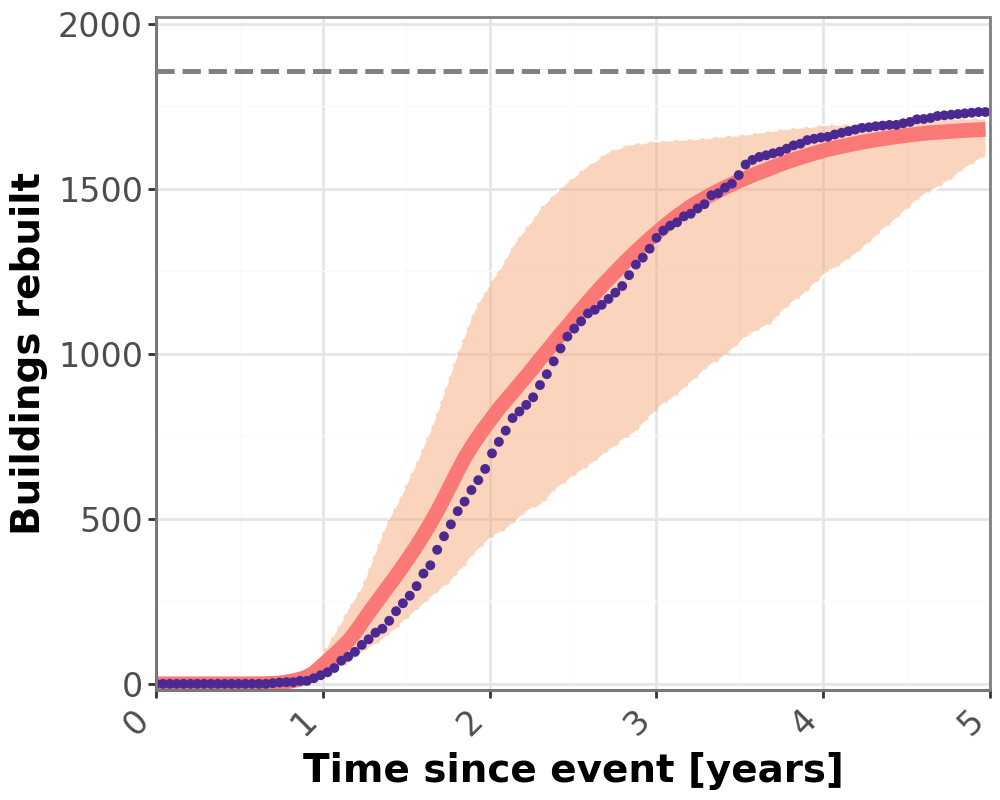

In [99]:
#############
# Plot

import plotly.express as px
color_sunset_0 = '#4c2991'
color_sunset_1 = '#f6aa7a'
color_sunset_2 = '#fa7876'

plot_base = ggplot() +  geom_ribbon(df_results,aes(x='Time/365',ymin='Min',ymax='Max'),fill=color_sunset_1,color='white',linetype='dashed',alpha=0.5)+\
                        geom_line(df_results,aes(x='Time/365',y='Mean'),color=color_sunset_2,linetype='solid',size=3)+\
                        geom_hline(yintercept=df_portfolio.shape[0], size=1, color='gray', linetype='dashed')+\
                        geom_point(df_results,aes(x='Time/365',y='Empirical'), shape='o',size=1,color=color_sunset_0)


plot_clean = plot_base + theme_bw() + theme(
  axis_line=element_line(size=1),
  axis_text=element_text(size=12),
  axis_title=element_text(size=14,face="bold"),
  axis_text_x = element_text(angle = 45, hjust=1),
) +\
theme(figure_size=(5, 4)) +\
scale_x_continuous(name = 'Time since event [years]',expand=[0,0],limits=[0,5]) +\
scale_y_continuous(name = 'Buildings rebuilt',expand=[0,20],limits=[0,2000])

plot_clean

## <font color='orange'> Benchmarks </font>

In [100]:
df_FEMA = pd.DataFrame()
error_happened = False
batch = 0

#for batch in range(2):
while error_happened == False:
    print(f'Working on batch {batch + 1}.')
    # batch size
    to_skip = batch * 10000


    # query path
    path = (f"https://www.fema.gov/api/open/v2/HousingAssistanceOwners?$top=10000&$filter=state eq 'CA'&$skip={int(to_skip)}")


    # query
    response = requests.get(path)


    # transform to data frame
    reff = pd.json_normalize(response.json(),'HousingAssistanceOwners')
    df = pd.DataFrame(data=reff)


    if df.shape[0] == 0:
        error_happened = True

    else:
        # select relevant data
        df = df[['disasterNumber','county','totalApprovedIhpAmount','repairReplaceAmount','rentalAmount','otherNeedsAmount']].copy()
        df = df[df['totalApprovedIhpAmount']>0].reset_index(drop=True)
        dfg = df.groupby(by=['disasterNumber','county']).sum().reset_index()

        # create output
        df_FEMA = pd.concat([df_FEMA,dfg],ignore_index=True)

    batch += 1

df_Tubbs = df_FEMA[df_FEMA['disasterNumber']==disaster_number]
IHP_Received = df_Tubbs[df_Tubbs['county']=='Sonoma (County)'].reset_index(drop=True).loc[0,'repairReplaceAmount']
IHP_Received

Working on batch 1.
Working on batch 2.


2126942.63

In [101]:
df_SBA_2018 = pd.read_csv('https://raw.githubusercontent.com/rccosta1/RAAbiT/refs/heads/main/Data/SBA_FY18.txt')
df_SBA_Sonoma = df_SBA_2018[(df_SBA_2018['FEMA Disaster Number']==4344) & (df_SBA_2018['Damaged Property State Code']=='CA') & (df_SBA_2018['Damaged Property County/Parish Name'] == 'SONOMA')]
HPPL_received = df_SBA_Sonoma['Approved Amount Real Estate'].sum()
HPPL_received

99280400.0

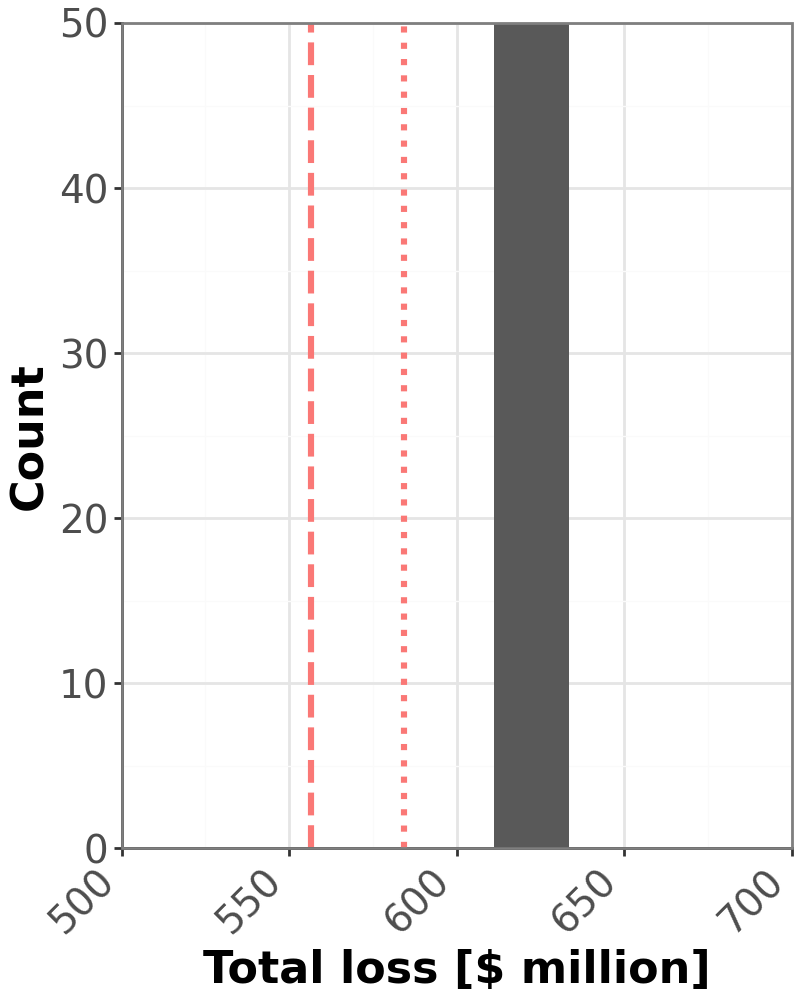

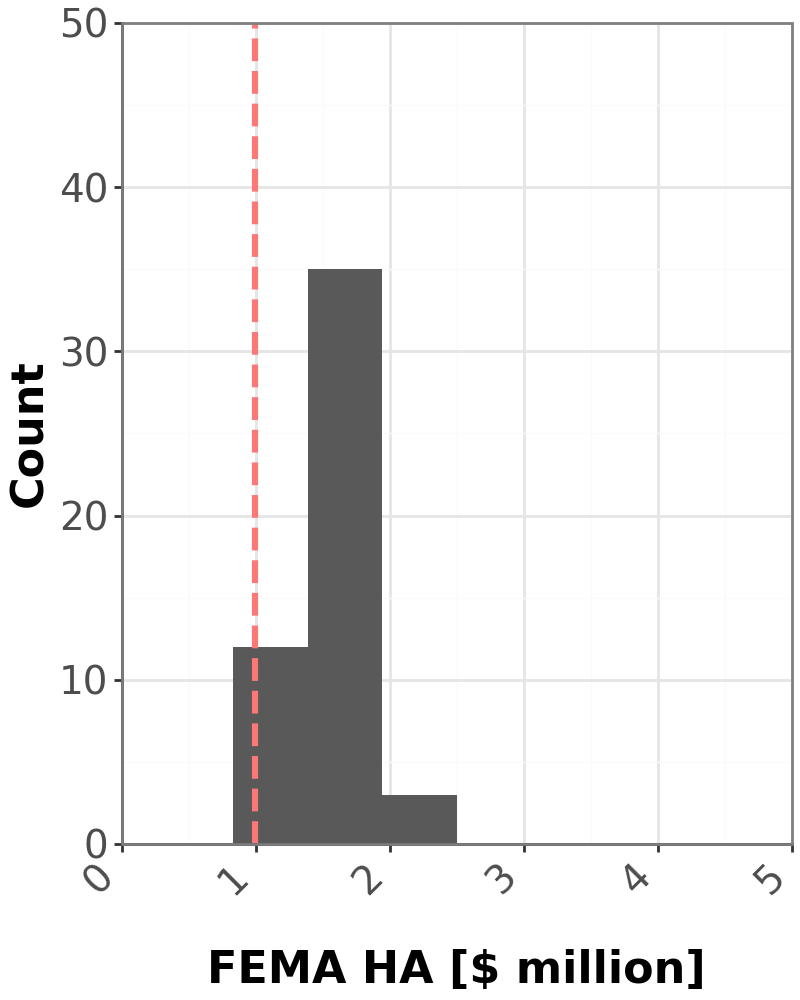

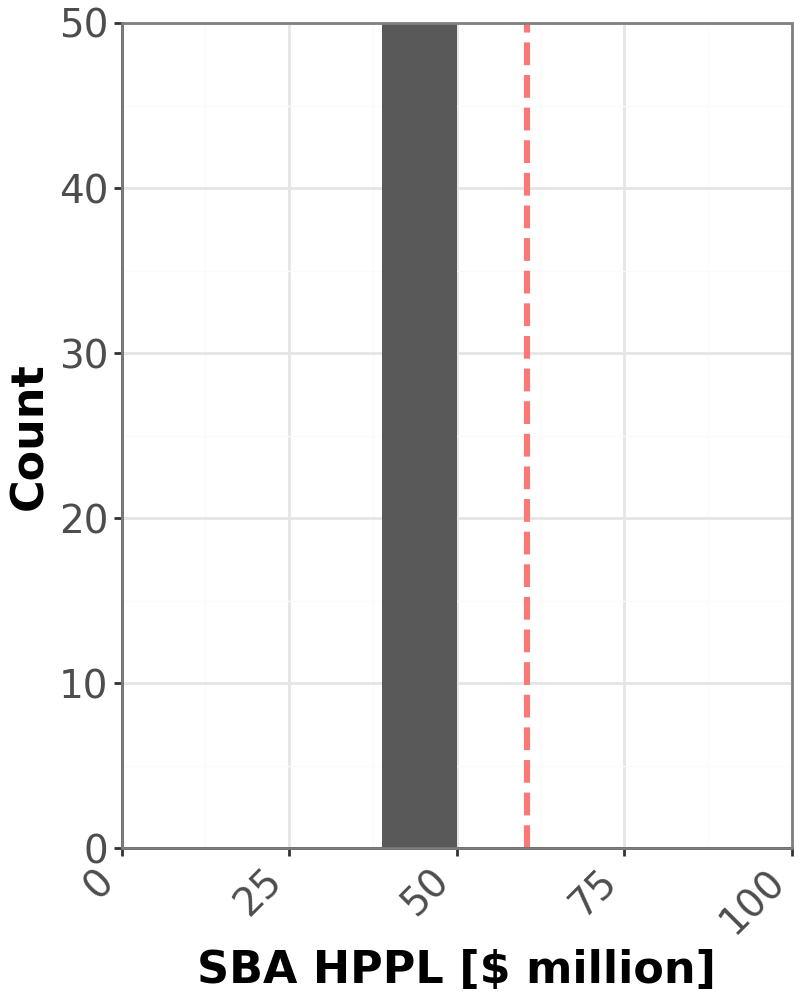

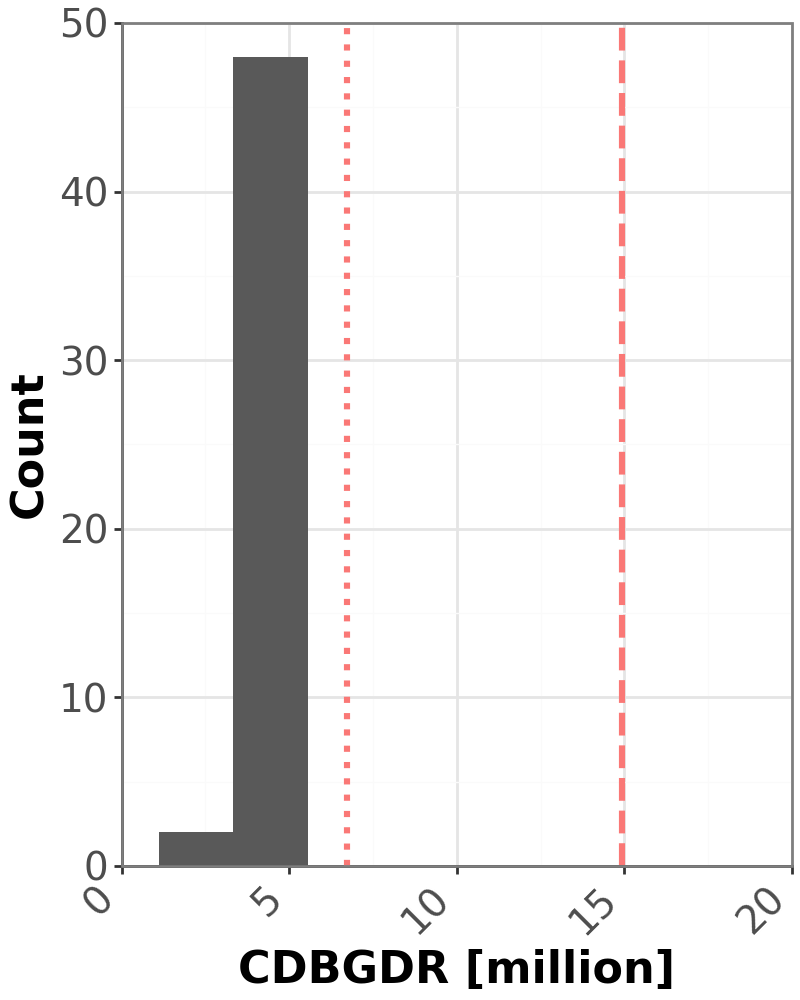

(<Figure Size: (400 x 500)>,
 <Figure Size: (400 x 500)>,
 <Figure Size: (400 x 500)>,
 <Figure Size: (400 x 500)>)

In [102]:
nblds = df_portfolio.shape[0]

# Simulation results
df_curve = df_results

# Financing results
df_plot = df_dollars

n_realizations = df_plot.shape[0]
hhs = df_portfolio.shape[0]

# 314,968 Figure 52, 2017 Action Plan
# Plots
plot_loss = ggplot(df_plot,aes(x='Loss / 10**6')) + geom_histogram(bins=10) +\
            geom_vline(xintercept = 300000*nblds/10**6,color=color_sunset_2,linetype='dashed',size=1.25) +\
            geom_vline(xintercept = 314968*nblds/10**6,color=color_sunset_2,linetype='dotted',size=1.25) +\
            annotate('text', x=297000*nblds/10**6, y = 220, label='HCD estimate',size=14,color='black',angle=90)+\
            annotate('text', x=311968*nblds/10**6, y = 220, label='SBA estimate',size=14,color='black',angle=90)+\
            theme_bw() + theme(
            axis_line=element_line(size=1),
            axis_text=element_text(size=14),
            axis_title=element_text(size=16,face="bold"),
            axis_text_x = element_text(angle = 45, hjust=1),
            ) +\
            theme(figure_size=(4, 5)) +\
            scale_x_continuous(name = 'Total loss [$ million]',expand=[0,0],limits=[500,700]) +\
            scale_y_continuous(name = 'Count',expand=[0,0],limits=[0,n_realizations])


# % owner-occupied = 0.677 (Action Plan Figure 9)
# 11058737 FEMA Website https://www.fema.gov/disaster/4344
# Peters paper: (3043 + 1963) = 5006/len(hhs_list) corrects the fact I have fewer buildings in my dataset
SR_blds = 3043
plot_ihp = ggplot(df_plot,aes(x='IHP / 10**6')) + geom_histogram(bins=10) +\
            geom_vline(xintercept = (0.52/0.677) * (nblds/SR_blds) * IHP_Received/10**6,color=color_sunset_2,linetype='dashed',size=1.25) +\
            annotate('text', x=0.82 * (0.52/0.677) * (nblds/SR_blds) * IHP_Received/10**6, y = 450, label='OpenFEMA estimate',size=14,color='black',angle=90)+\
            theme_bw() + theme(
            axis_line=element_line(size=1),
            axis_text=element_text(size=14),
            axis_title=element_text(size=16,face="bold"),
            axis_text_x = element_text(angle = 45, hjust=1),
            ) +\
            theme(figure_size=(4, 5)) +\
            scale_x_continuous(name = ' \nFEMA HA [$ million]',expand=[0,0],limits=[0,5]) +\
            scale_y_continuous(name = 'Count',expand=[0,0],limits=[0,n_realizations])


plot_sba = ggplot(df_plot,aes(x='SBA / 10**6')) + geom_histogram(bins=10) +\
            geom_vline(xintercept = (nblds/SR_blds) * HPPL_received/10**6,color=color_sunset_2,linetype='dashed',size=1.25) +\
            annotate('text', x=0.93*(nblds/SR_blds) * HPPL_received/10**6, y = 300, label='OpenSBA estimate',size=14,color='black',angle=90)+\
            theme_bw() + theme(
            axis_line=element_line(size=1),
            axis_text=element_text(size=14),
            axis_title=element_text(size=16,face="bold"),
            axis_text_x = element_text(angle = 45, hjust=1),
            ) +\
            theme(figure_size=(4, 5)) +\
            scale_x_continuous(name = 'SBA HPPL [$ million]',expand=[0,0],limits=[0,100]) +\
            scale_y_continuous(name = 'Count',expand=[0,0],limits=[0,n_realizations])


# Total expended in SF housing 21,470,000
# Share of destroyed buildings in Sonoma: 5154/7642 = 0.67
# % owner-occupied = 0.677 (Action Plan Figure 9)
# Estimated Sonoma + Santa Rosa share of SF housing = 9.74
plot_cdbg = ggplot(df_plot,aes(x='CDBGDR/10**6')) + geom_histogram(bins=10) +\
            geom_vline(xintercept = (0.52/0.677) * 0.67 * 47.63 * df_portfolio.shape[0]/SR_blds,color=color_sunset_2,linetype='dashed',size=1.25) +\
            geom_vline(xintercept = (0.52/0.677) * 0.67 * 21.47 * df_portfolio.shape[0]/SR_blds,color=color_sunset_2,linetype='dotted',size=1.25) +\
            annotate('text', x=0.94 * (0.52/0.677) * 0.67 * 47.63 * df_portfolio.shape[0]/SR_blds, y = 400, label='CDBG-DR initial allocation',size=14,color='black',angle=90)+\
            annotate('text', x=0.91 * (0.52/0.677) * 0.67 * 21.47 * df_portfolio.shape[0]/SR_blds, y = 400, label='CDBG-DR final allocation',size=14,color='black',angle=90)+\
            theme_bw() + theme(
            axis_line=element_line(size=1),
            axis_text=element_text(size=14),
            axis_title=element_text(size=16,face="bold"),
            axis_text_x = element_text(angle = 45, hjust=1),
            ) +\
            theme(figure_size=(4, 5)) +\
            scale_x_continuous(name = 'CDBGDR [million]',expand=[0,0],limits=[0,20]) +\
            scale_y_continuous(name = 'Count',expand=[0,0],limits=[0,n_realizations])

plot_loss, plot_ihp, plot_sba, plot_cdbg

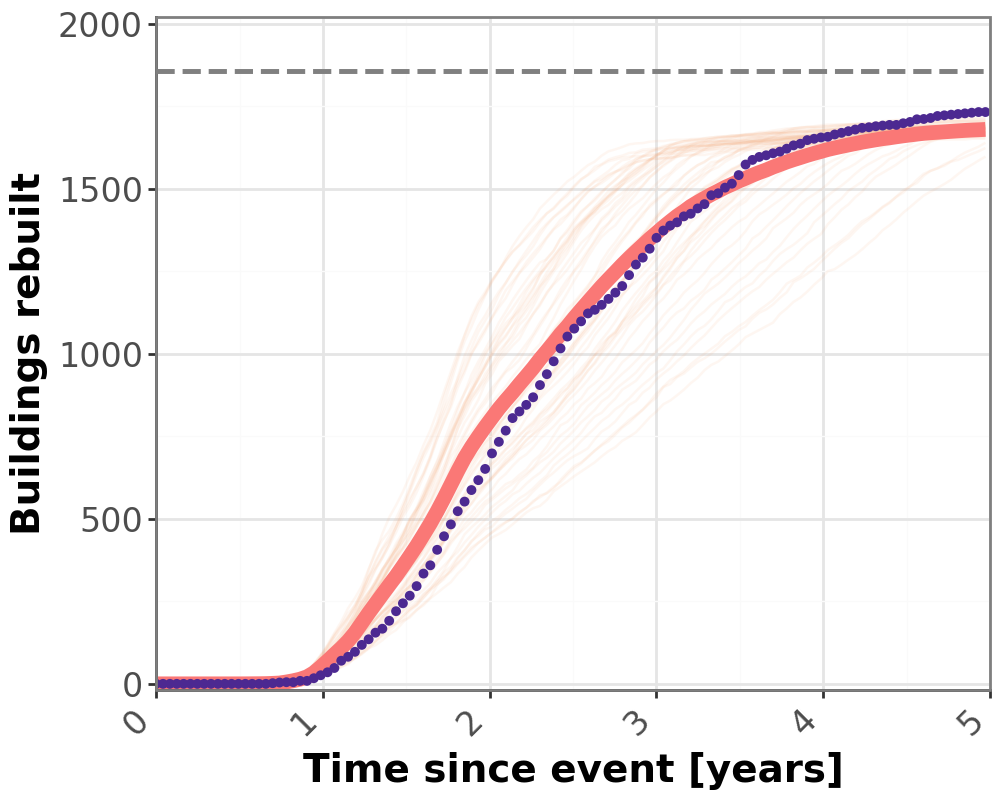

In [103]:
sim_type = 'OOT'
wrkr_behavior = 'Density'
improv = 'None'
file_name = 'sim_' + improv + '_' + str(sim_type) + '__bhv_' + str(wrkr_behavior) + '.csv'

# Portfolio
df_Portfolio = df_portfolio
nblds = df_portfolio.shape[0]

# Simulation results
df_curve = df_results

# Financing results
df_plot = df_dollars

n_realizations = df_plot.shape[0]
hhs = df_Portfolio.shape[0]

df_realizations = df_curve.iloc[:,:-5].copy()
df_realizations['Time'] = df_curve['Time']
df_curves_long = pd.melt(df_realizations,id_vars='Time')

# Plots
plot_base = ggplot() +  geom_line(df_curves_long,aes(x='Time/365',y='value',group='variable'),color=color_sunset_1, alpha=0.1)+\
                        geom_line(df_curve,aes(x='Time/365',y='Mean'),color=color_sunset_2,linetype='solid',size=3)+\
                        geom_point(df_curve,aes(x='Time/365',y='Empirical'), shape='o',size=1,color=color_sunset_0)+\
                        geom_hline(yintercept=df_Portfolio.shape[0], size=1, color='gray', linetype='dashed')


curve_oot_prox = plot_base + theme_bw() + theme(
  axis_line=element_line(size=1),
  axis_text=element_text(size=12),
  axis_title=element_text(size=14,face="bold"),
  axis_text_x = element_text(angle = 45, hjust=1),
) +\
theme(figure_size=(5, 4)) +\
scale_x_continuous(name = 'Time since event [years]',expand=[0,0],limits=[0,5]) +\
scale_y_continuous(name = 'Buildings rebuilt',expand=[0,20],limits=[0,2000])

curve_oot_prox

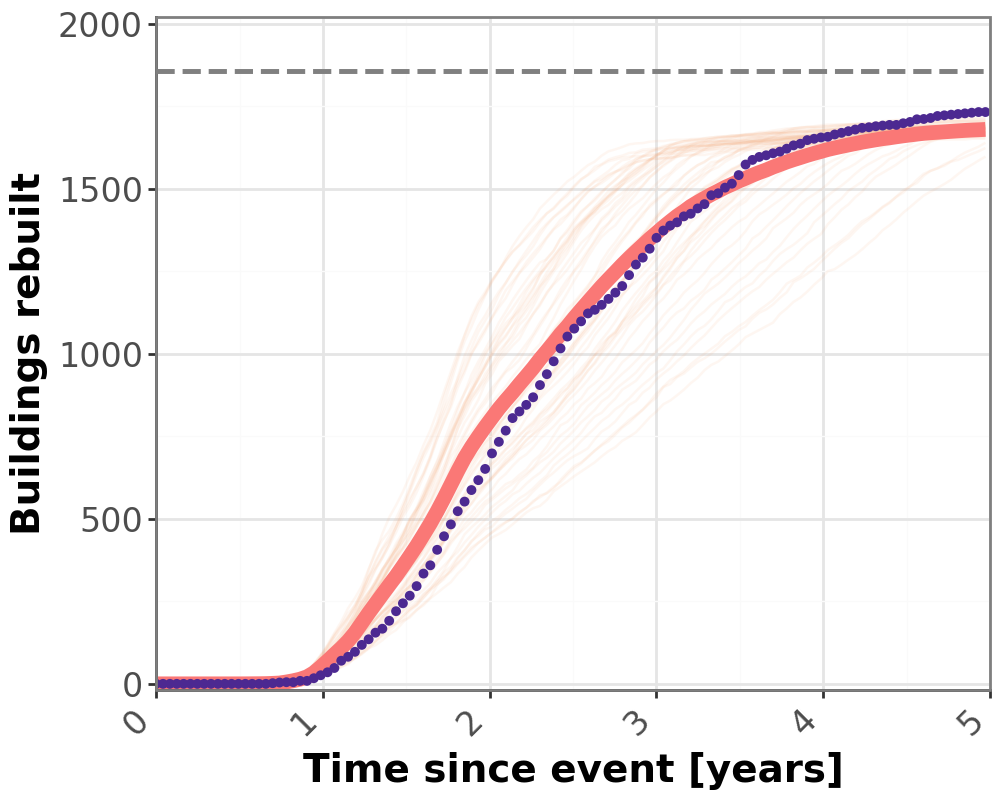

In [104]:
sim_type = 'OOT'
wrkr_behavior = 'FCFS'
improv = 'None'
file_name = 'sim_' + improv + '_' + str(sim_type) + '__bhv_' + str(wrkr_behavior) + '.csv'

# Portfolio
df_Portfolio = df_portfolio
nblds = df_portfolio.shape[0]

# Simulation results
df_curve = df_results

# Financing results
df_plot = df_dollars

n_realizations = df_plot.shape[0]
hhs = df_Portfolio.shape[0]

df_realizations = df_curve.iloc[:,:-5].copy()
df_realizations['Time'] = df_curve['Time']
df_curves_long = pd.melt(df_realizations,id_vars='Time')

# Plots
plot_base = ggplot() +  geom_line(df_curves_long,aes(x='Time/365',y='value',group='variable'),color=color_sunset_1, alpha=0.1)+\
                        geom_line(df_curve,aes(x='Time/365',y='Mean'),color=color_sunset_2,linetype='solid',size=3)+\
                        geom_point(df_curve,aes(x='Time/365',y='Empirical'), shape='o',size=1,color=color_sunset_0)+\
                        geom_hline(yintercept=df_Portfolio.shape[0], size=1, color='gray', linetype='dashed')


curve_oot_fcfs = plot_base + theme_bw() + theme(
  axis_line=element_line(size=1),
  axis_text=element_text(size=12),
  axis_title=element_text(size=14,face="bold"),
  axis_text_x = element_text(angle = 45, hjust=1),
) +\
theme(figure_size=(5, 4)) +\
scale_x_continuous(name = 'Time since event [years]',expand=[0,0],limits=[0,5]) +\
scale_y_continuous(name = 'Buildings rebuilt',expand=[0,20],limits=[0,2000])

curve_oot_fcfs

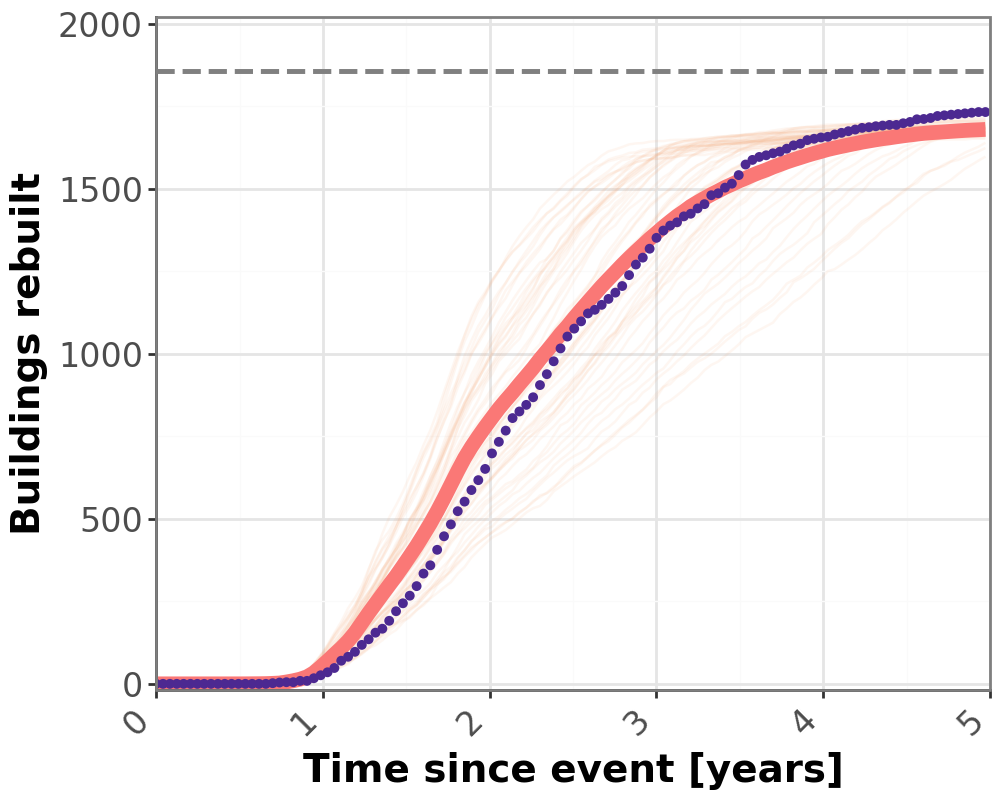

In [105]:
sim_type = 'OOT'
wrkr_behavior = 'Random'
improv = 'None'
file_name = 'sim_' + improv + '_' + str(sim_type) + '__bhv_' + str(wrkr_behavior) + '.csv'

# Portfolio
df_Portfolio = df_portfolio
nblds = df_portfolio.shape[0]

# Simulation results
df_curve = df_results

# Financing results
df_plot = df_dollars

n_realizations = df_plot.shape[0]
hhs = df_Portfolio.shape[0]

df_realizations = df_curve.iloc[:,:-5].copy()
df_realizations['Time'] = df_curve['Time']
df_curves_long = pd.melt(df_realizations,id_vars='Time')

# Plots
plot_base = ggplot() +  geom_line(df_curves_long,aes(x='Time/365',y='value',group='variable'),color=color_sunset_1, alpha=0.1)+\
                        geom_line(df_curve,aes(x='Time/365',y='Mean'),color=color_sunset_2,linetype='solid',size=3)+\
                        geom_point(df_curve,aes(x='Time/365',y='Empirical'), shape='o',size=1,color=color_sunset_0)+\
                        geom_hline(yintercept=df_Portfolio.shape[0], size=1, color='gray', linetype='dashed')


curve_oot_random = plot_base + theme_bw() + theme(
  axis_line=element_line(size=1),
  axis_text=element_text(size=12),
  axis_title=element_text(size=14,face="bold"),
  axis_text_x = element_text(angle = 45, hjust=1),
) +\
theme(figure_size=(5, 4)) +\
scale_x_continuous(name = 'Time since event [years]',expand=[0,0],limits=[0,5]) +\
scale_y_continuous(name = 'Buildings rebuilt',expand=[0,20],limits=[0,2000])

curve_oot_random

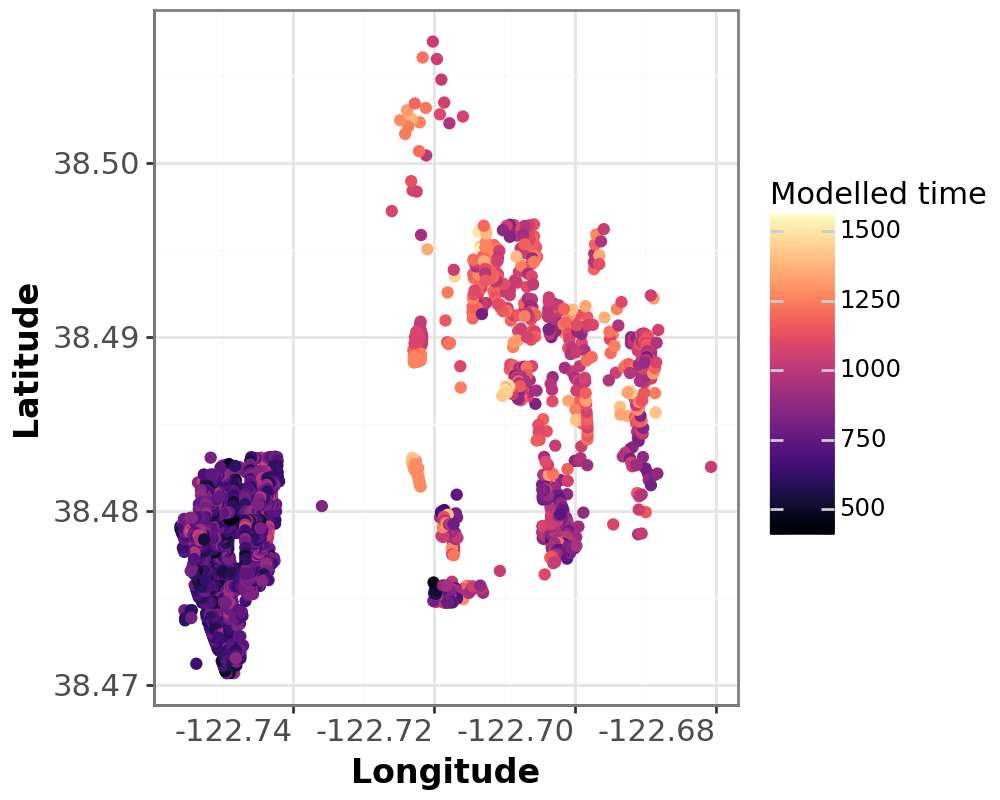

In [106]:
df = df_Portfolio[df_Portfolio['TimetoFinal'] > 0].copy().reset_index(drop=True)
n_neis = 5


knn = NearestNeighbors(n_neighbors=n_neis)
knn.fit(df[['Latitude','Longitude']])

nearest = knn.kneighbors(df[['Latitude','Longitude']],n_neighbors=n_neis,return_distance=False)
df['Neigbours'] = [nearest[i] for i in range(len(nearest))]

v = []
for i in range(df.shape[0]):
    nns = df.loc[i,'Neigbours'][1:]
    s = []
    for j in nns:
        s.append(df.loc[j,'TimetoFinal'])
    v.append(np.nanmean(s))
df['Empirical\nSpatial lag\n[days]'] = v

ggplot(df,aes(x='Longitude',y='Latitude',color='Empirical\nSpatial lag\n[days]')) + geom_point()+\
scale_x_continuous(name = 'Longitude') +\
scale_y_continuous(name = 'Latitude')+\
theme_bw() + theme(
            axis_line=element_line(size=1),
            axis_text=element_text(size=11),
            axis_title=element_text(size=12,face="bold"),
            axis_text_x = element_text(angle = 0, hjust=1),
            ) +\
            scale_color_continuous(name = 'Modelled time',cmap_name='magma')+\
            theme(figure_size=(5, 4)) +\
            scale_x_continuous(name = 'Longitude') +\
            scale_y_continuous(name = 'Latitude')

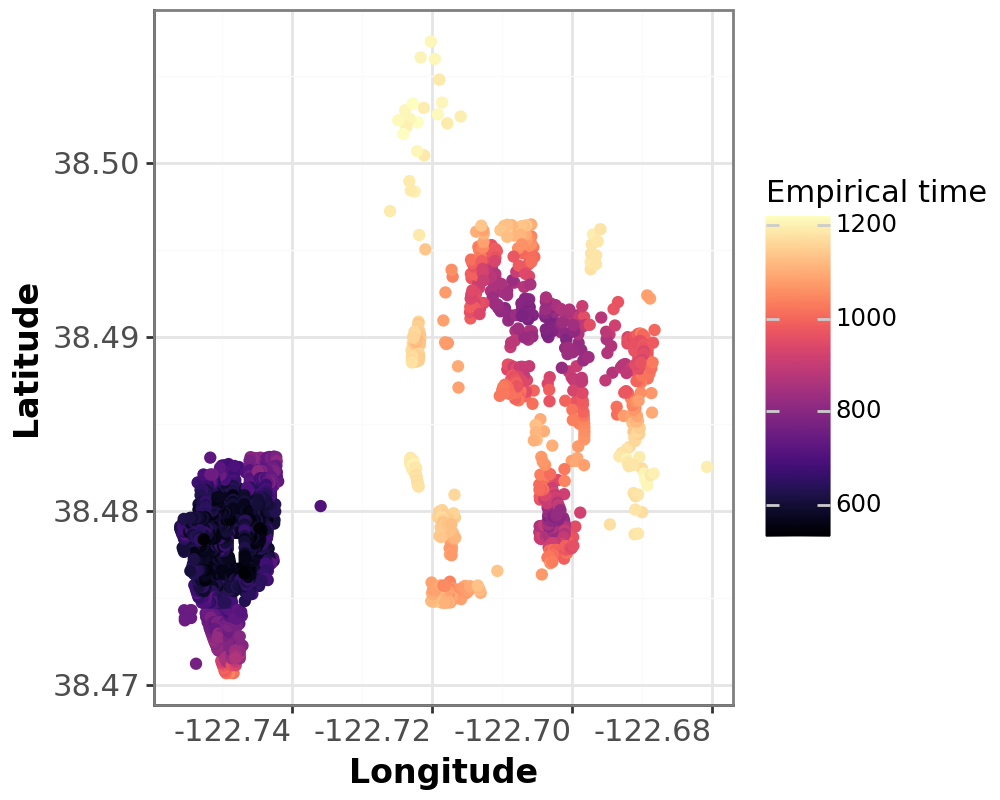

In [107]:
knn = NearestNeighbors(n_neighbors=n_neis)
knn.fit(df[['Latitude','Longitude']])

nearest = knn.kneighbors(df[['Latitude','Longitude']],n_neighbors=n_neis,return_distance=False)
df['Neigbours'] = [nearest[i] for i in range(len(nearest))]

cols = ['R'+str(i) for i in range(n_realizations)]
df['mean_s'] = df.loc[:,cols].mean(axis=1,skipna=True)

v = []
for i in range(df.shape[0]):
    nns = df.loc[i,'Neigbours'][1:]
    s = []
    for j in nns:
        s.append(df.loc[j,'mean_s'])
    v.append(np.nanmean(s))
df['Model\nSpatial lag\n[days]'] = v

ggplot(df,aes(x='Longitude',y='Latitude',color='Model\nSpatial lag\n[days]')) + geom_point()+\
scale_x_continuous(name = 'Longitude') +\
scale_y_continuous(name = 'Latitude') +\
theme_bw() + theme(
            axis_line=element_line(size=1),
            axis_text=element_text(size=11),
            axis_title=element_text(size=12,face="bold"),
            axis_text_x = element_text(angle = 0, hjust=1),
            ) +\
            scale_color_continuous(name = 'Empirical time',cmap_name='magma')+\
            theme(figure_size=(5, 4)) +\
            scale_x_continuous(name = 'Longitude') +\
            scale_y_continuous(name = 'Latitude')

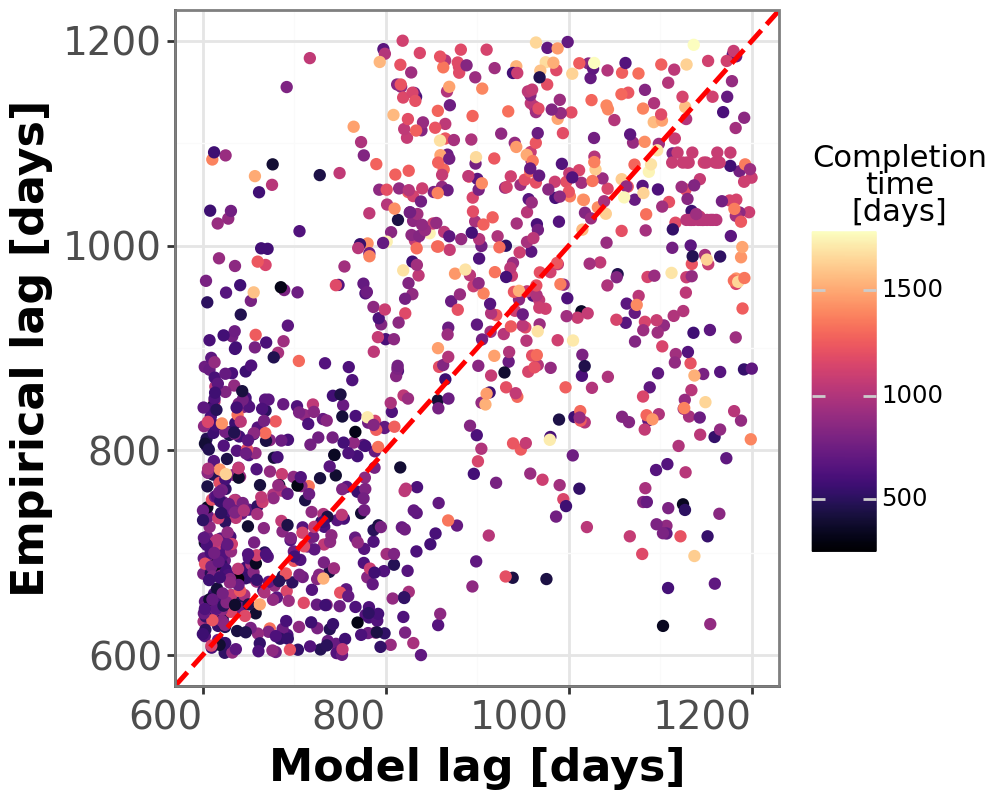

In [108]:
ggplot(df,aes(x='Model\nSpatial lag\n[days]',y='Empirical\nSpatial lag\n[days]',color='TimetoFinal')) + geom_point() +\
     geom_abline(slope=1,size=1,color='red',linetype='dashed')+\
     theme_bw() + theme(
            axis_line=element_line(size=1),
            axis_text=element_text(size=14),
            axis_title=element_text(size=16,face="bold"),
            axis_text_x = element_text(angle = 0, hjust=1),
            ) +\
            theme(figure_size=(5, 4)) +\
            scale_color_continuous(name='Completion\ntime\n[days]',cmap_name="magma")+\
            scale_x_continuous(name = 'Model lag [days]',limits=[600,1200]) +\
            scale_y_continuous(name = 'Empirical lag [days]',limits=[600,1200])

In [109]:
np.corrcoef(df['Model\nSpatial lag\n[days]'],df['Empirical\nSpatial lag\n[days]'])

array([[1.        , 0.67529227],
       [0.67529227, 1.        ]])

In [110]:
sts.spearmanr(a=df['Model\nSpatial lag\n[days]'],b=df['Empirical\nSpatial lag\n[days]'])

SignificanceResult(statistic=0.6528600749589387, pvalue=6.0029339694142224e-211)



---



---



# End of file